In [ ]:
!pip install yfinance pandas numpy matplotlib scipy scikit-learn tensorflow seaborn arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.3/978.3 kB 12.9 MB/s eta 0:00:00


1. What was the change in price of the stock over time?


=== DataFrame.info() (full OHLCV panel) ===
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2703 entries, 2015-01-02 to 2025-10-01
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Adj Close, AAPL)  2703 non-null   float64
 1   (Adj Close, AMZN)  2703 non-null   float64
 2   (Adj Close, GOOG)  2703 non-null   float64
 3   (Adj Close, MSFT)  2703 non-null   float64
 4   (Close, AAPL)      2703 non-null   float64
 5   (Close, AMZN)      2703 non-null   float64
 6   (Close, GOOG)      2703 non-null   float64
 7   (Close, MSFT)      2703 non-null   float64
 8   (High, AAPL)       2703 non-null   float64
 9   (High, AMZN)       2703 non-null   float64
 10  (High, GOOG)       2703 non-null   float64
 11  (High, MSFT)       2703 non-null   float64
 12  (Low, AAPL)        2703 non-null   float64
 13  (Low, AMZN)        2703 non-null   float64
 14  (Low, GOOG)        2703 non-null   float64
 15  (Low, MSF

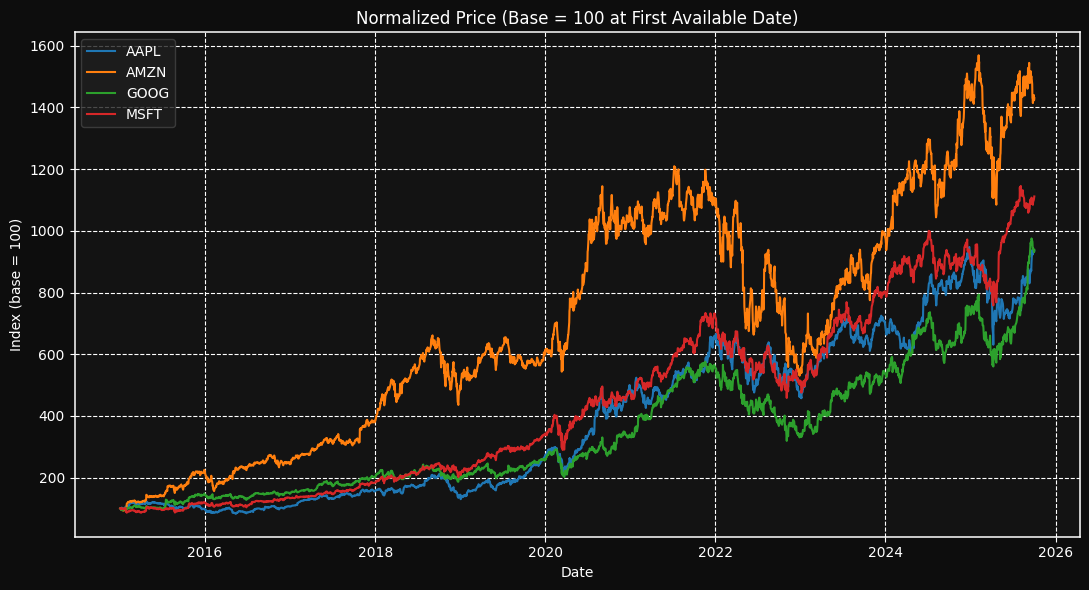

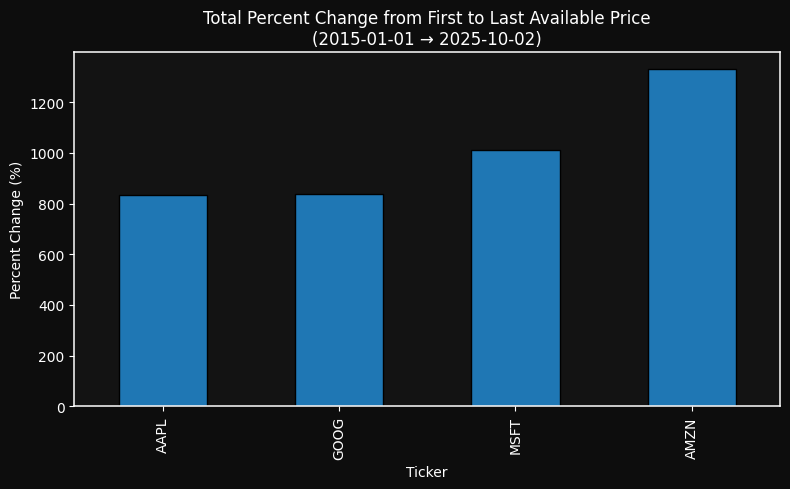

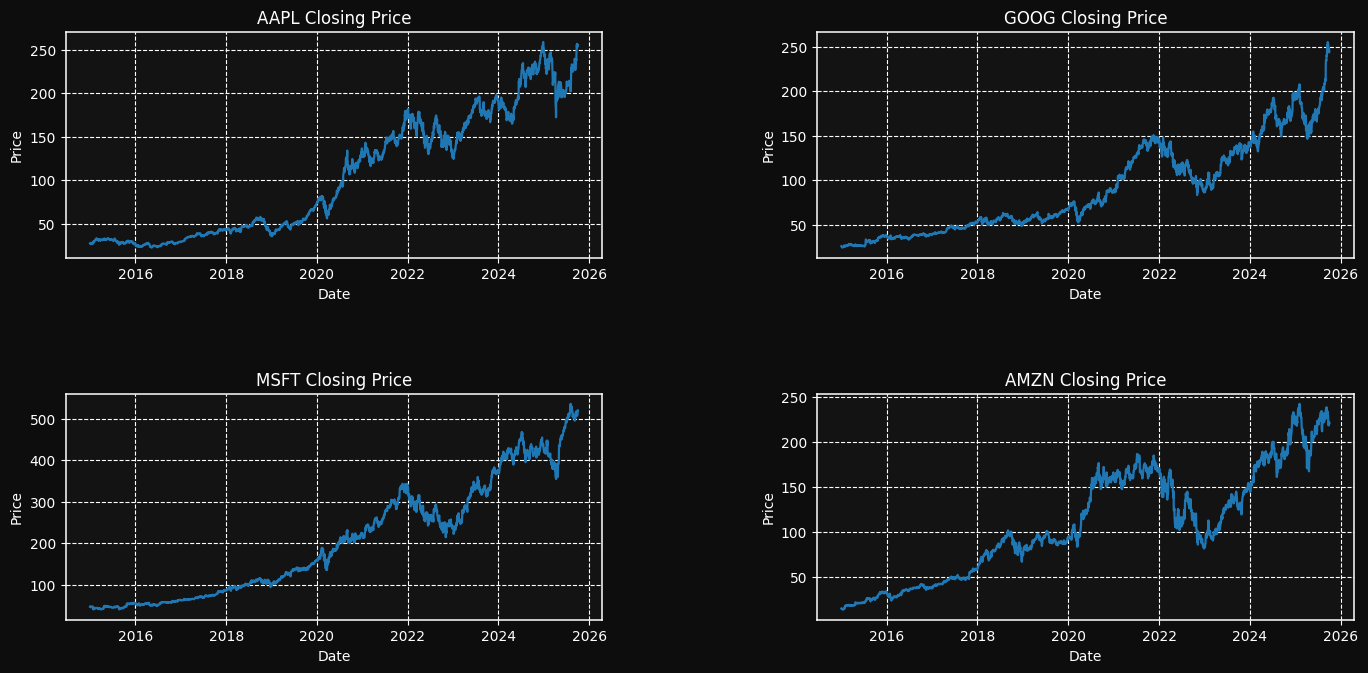

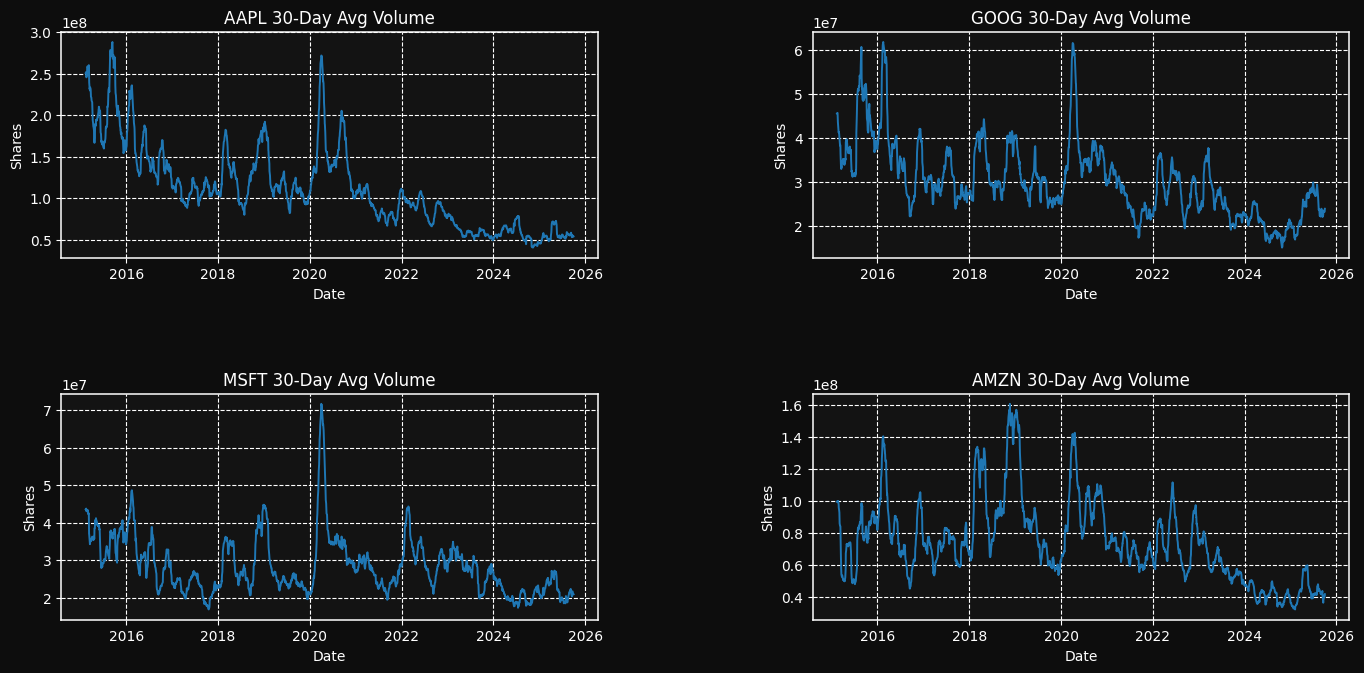

In [ ]:
"""
Q1. Change in price over time with Close, Volume, Company Description
Tickers: AAPL, GOOG, MSFT, AMZN

Update:
- All plots (including Closing Price & 30-Day Avg Volume grids) now use dark-readable styling:
  white titles/labels/ticks on dark panels + wide spacing between subplots.
"""

import io
import textwrap
from datetime import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf

# ---------- Parameters ----------
tickers = ["AAPL", "GOOG", "MSFT", "AMZN"]
start   = "2015-01-01"
end     = datetime.today().strftime("%Y-%m-%d")

# visual separation & colors
FIG_BG = "#0d0d0d"       # figure (gap) background
AX_BG_DARK = "#131313"   # axes background for all plots
TXT_LIGHT = "white"
GRID_LIGHT = (1, 1, 1, 0.22)  # faint grid on dark
GAP_W  = 0.40
GAP_H  = 0.60
# --------------------------------

def style_dark_axes(ax):
    """Readable dark styling for axes."""
    ax.set_facecolor(AX_BG_DARK)
    ax.title.set_color(TXT_LIGHT)
    ax.xaxis.label.set_color(TXT_LIGHT)
    ax.yaxis.label.set_color(TXT_LIGHT)
    ax.tick_params(colors=TXT_LIGHT)
    for spine in ax.spines.values():
        spine.set_color(TXT_LIGHT)
        spine.set_linewidth(1.1)
    ax.grid(True, linestyle="--", color=GRID_LIGHT)

def style_dark_legend(ax):
    leg = ax.legend(frameon=True, facecolor="#1f1f1f", edgecolor="#444", loc="upper left")
    if leg:
        for text in leg.get_texts():
            text.set_color(TXT_LIGHT)

# 1) Download OHLCV (keep Adj Close)
panel = yf.download(
    tickers, start=start, end=end,
    auto_adjust=False, progress=False
)
if panel.empty:
    raise ValueError("No data downloaded. Check tickers/date range/network.")

# 2) DataFrame.info()
print("\n=== DataFrame.info() (full OHLCV panel) ===")
buf = io.StringIO()
panel.info(buf=buf)
print(buf.getvalue())

# 3) Company descriptions
def get_company_meta(t):
    info = {}
    try:
        info = yf.Ticker(t).get_info() or yf.Ticker(t).info
    except Exception:
        pass
    long_name = (info or {}).get("longName") or (info or {}).get("shortName") or t
    sector    = (info or {}).get("sector") or "N/A"
    industry  = (info or {}).get("industry") or (info or {}).get("industryKey") or "N/A"
    summary   = (info or {}).get("longBusinessSummary") or "Description not available."
    summary_wrapped = "\n".join(textwrap.wrap(summary, width=100))
    return long_name, sector, industry, summary_wrapped

print("\n=== Company Descriptions ===")
for t in tickers:
    name, sector, industry, summary = get_company_meta(t)
    print(f"\n[{t}] {name}")
    print(f"Sector: {sector} | Industry: {industry}")
    print(summary)

# 4) Separate Close & Volume frames
if isinstance(panel.columns, pd.MultiIndex):
    close = panel["Close"].copy()
    vol   = panel["Volume"].copy()
else:
    close = panel[["Close"]].copy(); close.columns = tickers[:1]
    vol   = panel[["Volume"]].copy(); vol.columns = tickers[:1]

# 5) Per-ticker describe() (Open/High/Low/Close/Adj Close/Volume)
print("\n=== Per-Ticker describe() (Open, High, Low, Close, Adj Close, Volume) ===")
for t in tickers:
    if isinstance(panel.columns, pd.MultiIndex):
        cols = ["Open","High","Low","Close","Adj Close","Volume"]
        existing = [c for c in cols if (c, t) in panel.columns]
        if not existing:
            print(f"\n[{t}] No OHLCV columns found. Skipping.")
            continue
        tdf = panel.xs(t, axis=1, level=1)[existing]
    else:
        tdf = panel[["Open","High","Low","Close","Adj Close","Volume"]].copy()
    print(f"\n[{t}] describe():")
    print(tdf.describe())

# 6) Summary table
summary_rows = []
for t in tickers:
    s_close = close.get(t, pd.Series(dtype=float)).dropna()
    s_vol   = vol.get(t, pd.Series(dtype=float)).dropna()
    if s_close.empty:
        print(f"Warning: missing Close data for {t}. Skipping summary.")
        continue
    start_dt  = s_close.index[0]
    end_dt    = s_close.index[-1]
    start_px  = float(s_close.iloc[0])
    end_px    = float(s_close.iloc[-1])
    abs_chg   = end_px - start_px
    pct_chg   = (abs_chg / start_px) * 100
    last_close = float(s_close.iloc[-1])
    last_vol   = int(s_vol.iloc[-1]) if not s_vol.empty else None
    avg_vol    = int(s_vol.mean())   if not s_vol.empty else None

    summary_rows.append({
        "Ticker": t,
        "Start Date": start_dt.date(),
        "End Date": end_dt.date(),
        "Start Close": round(start_px, 2),
        "End Close": round(end_px, 2),
        "Abs Change": round(abs_chg, 2),
        "Pct Change (%)": round(pct_chg, 2),
        "Last Close": round(last_close, 2),
        "Last Volume": last_vol,
        "Avg Daily Volume": avg_vol
    })

summary = pd.DataFrame(summary_rows).set_index("Ticker").reindex(tickers)
print("\n=== Change in Price & Volume Summary ===")
print(summary)

# 7) Plots
# (a) Normalized Close (base=100) — dark axes
norm = pd.DataFrame(index=close.index)
for t in close.columns:
    s = close[t].dropna()
    if not s.empty:
        norm[t] = (s / s.iloc[0]) * 100

fig, ax = plt.subplots(figsize=(11,6))
fig.patch.set_facecolor(FIG_BG)
style_dark_axes(ax)
for t in norm.columns:
    ax.plot(norm.index, norm[t], label=t, linewidth=1.5)
ax.set_title("Normalized Price (Base = 100 at First Available Date)")
ax.set_xlabel("Date"); ax.set_ylabel("Index (base = 100)")
style_dark_legend(ax)
fig.tight_layout()
plt.show()

# (b) Percent change bars — dark axes
fig, ax = plt.subplots(figsize=(8,5))
fig.patch.set_facecolor(FIG_BG)
style_dark_axes(ax)
summary["Pct Change (%)"].plot(kind="bar", edgecolor="black", ax=ax)
ax.set_title(f"Total Percent Change from First to Last Available Price\n({start} → {end})")
ax.set_ylabel("Percent Change (%)")
fig.tight_layout()
plt.show()

# (c) Closing Price line plots (2x2) — NOW dark axes + wide spacing
fig, axes = plt.subplots(2, 2, figsize=(14, 7), sharex=False, sharey=False)
fig.patch.set_facecolor(FIG_BG)
axes = axes.ravel()
for i, t in enumerate(tickers):
    ax = axes[i]
    if t not in close.columns:
        ax.set_visible(False)
        continue
    style_dark_axes(ax)
    s = close[t].dropna()
    ax.plot(s.index, s.values, linewidth=1.6)
    ax.set_title(f"{t} Closing Price")
    ax.set_xlabel("Date"); ax.set_ylabel("Price")

fig.subplots_adjust(left=0.06, right=0.98, top=0.92, bottom=0.08,
                    wspace=GAP_W, hspace=GAP_H)
plt.show()

# (d) 30-day average Volume (2x2) — NOW dark axes + wide spacing
fig, axes = plt.subplots(2, 2, figsize=(14, 7), sharex=False, sharey=False)
fig.patch.set_facecolor(FIG_BG)
axes = axes.ravel()
for i, t in enumerate(tickers):
    ax = axes[i]
    if t not in vol.columns:
        ax.set_visible(False)
        continue
    style_dark_axes(ax)
    v = vol[t].dropna().rolling(30).mean()
    ax.plot(v.index, v.values, linewidth=1.4)
    ax.set_title(f"{t} 30-Day Avg Volume")
    ax.set_xlabel("Date"); ax.set_ylabel("Shares")

fig.subplots_adjust(left=0.06, right=0.98, top=0.92, bottom=0.08,
                    wspace=GAP_W, hspace=GAP_H)
plt.show()

2. What was the moving average of the various stocks?

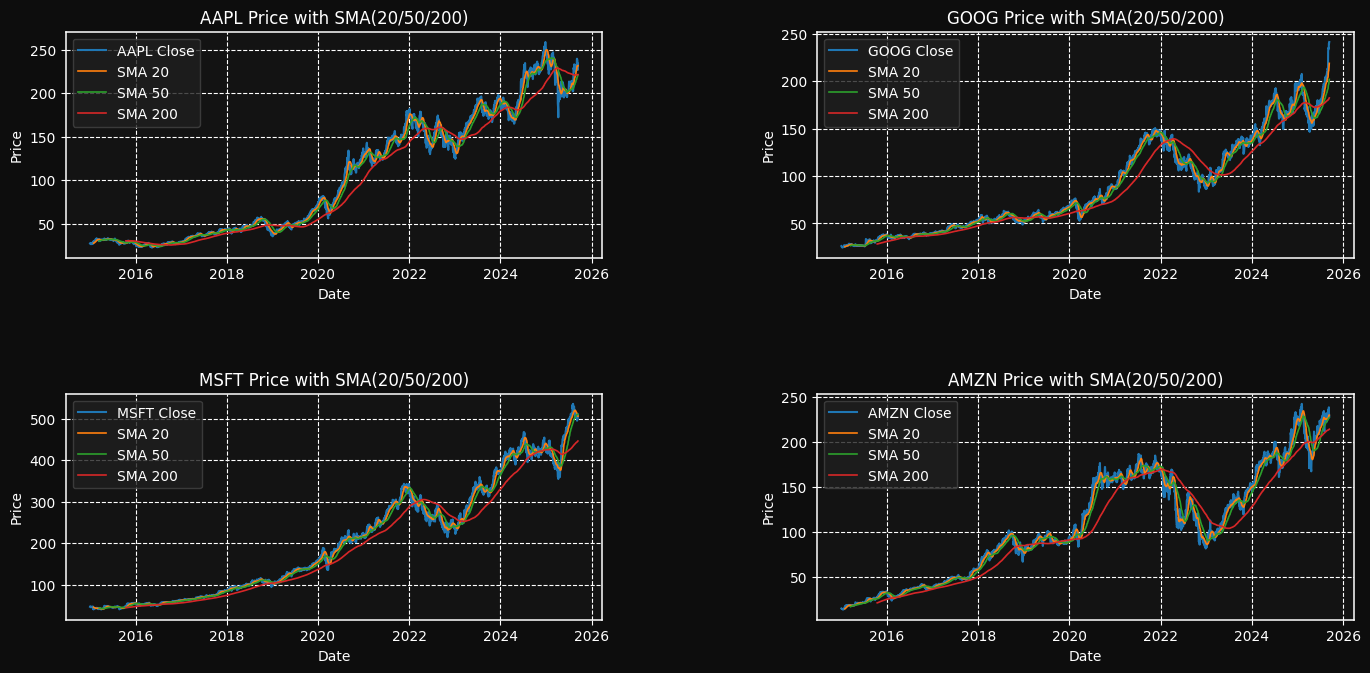

In [ ]:
"""
Moving Averages (AAPL, GOOG, MSFT, AMZN)
- Downloads OHLCV
- Computes SMA(20/50/200) on Close
- Plots price + SMAs in a 2x2 grid with wide spacing (dark theme)
"""

# ---------- Parameters ----------
tickers = ["AAPL", "GOOG", "MSFT", "AMZN"]
start   = "2015-01-01"
end     = datetime.today().strftime("%Y-%m-%d")

# Dark styling & spacing
FIG_BG      = "#0d0d0d"
AX_BG_DARK  = "#131313"
TXT_LIGHT   = "white"
GRID_LIGHT  = (1, 1, 1, 0.22)
GAP_W, GAP_H = 0.40, 0.60
# --------------------------------

def style_dark_axes(ax):
    ax.set_facecolor(AX_BG_DARK)
    ax.title.set_color(TXT_LIGHT)
    ax.xaxis.label.set_color(TXT_LIGHT)
    ax.yaxis.label.set_color(TXT_LIGHT)
    ax.tick_params(colors=TXT_LIGHT)
    for s in ax.spines.values():
        s.set_color(TXT_LIGHT); s.set_linewidth(1.1)
    ax.grid(True, linestyle="--", color=GRID_LIGHT)

def style_dark_legend(ax, loc="upper left"):
    leg = ax.legend(frameon=True, facecolor="#1f1f1f", edgecolor="#444", loc=loc)
    if leg:
        for txt in leg.get_texts():
            txt.set_color(TXT_LIGHT)

# 1) Download
panel = yf.download(tickers, start=start, end=end, auto_adjust=False, progress=False)
if panel.empty:
    raise RuntimeError("No data downloaded. Check tickers/date range/network.")

# 2) Close prices
if isinstance(panel.columns, pd.MultiIndex):
    close = panel["Close"].copy()
else:
    close = panel[["Close"]].copy()
    close.columns = tickers[:1]

# 3) Plot Price + SMAs (20/50/200)
fig, axes = plt.subplots(2, 2, figsize=(14, 7), sharex=False, sharey=False)
fig.patch.set_facecolor(FIG_BG)
axes = axes.ravel()

for i, t in enumerate(tickers):
    ax = axes[i]
    style_dark_axes(ax)

    if t not in close.columns or close[t].dropna().empty:
        ax.set_title(f"{t} — no price data")
        continue

    s = close[t].dropna()
    sma20  = s.rolling(20).mean()
    sma50  = s.rolling(50).mean()
    sma200 = s.rolling(200).mean()

    ax.plot(s.index, s.values, label=f"{t} Close", linewidth=1.5)
    ax.plot(sma20.index, sma20.values, label="SMA 20",  linewidth=1.2)
    ax.plot(sma50.index, sma50.values, label="SMA 50",  linewidth=1.2)
    ax.plot(sma200.index, sma200.values, label="SMA 200", linewidth=1.2)

    ax.set_title(f"{t} Price with SMA(20/50/200)")
    ax.set_xlabel("Date"); ax.set_ylabel("Price")
    style_dark_legend(ax, loc="upper left")

fig.subplots_adjust(left=0.06, right=0.98, top=0.92, bottom=0.08,
                    wspace=GAP_W, hspace=GAP_H)
plt.show()

3. What was the daily return of the stock on average and Rolling Mean and EWMA?


=== Average Daily Return Summary (2018-01-01 → 2025-09-15) ===
        Daily Mean  Daily Std  Ann. Mean  Ann. Std   Sharpe~
Ticker                                                      
MSFT      0.001126   0.018062   0.327995  0.286721  0.989917
AAPL      0.001101   0.019630   0.319672  0.311624  0.890610
GOOG      0.000976   0.019515   0.278591  0.309788  0.793700
AMZN      0.000932   0.021757   0.264627  0.345374  0.680093


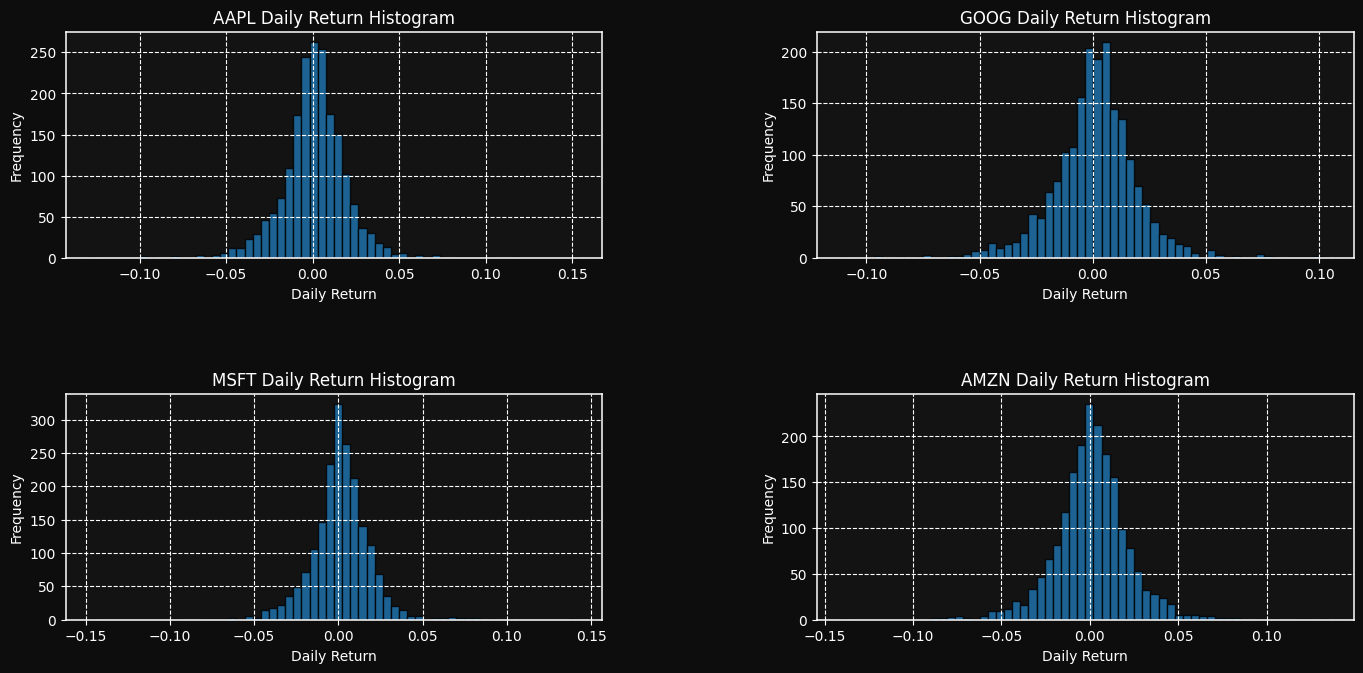


=== Most Recent 30-Day Rolling Mean of Daily Returns ===
        Last 30d Mean
Ticker               
AAPL         0.004219
AMZN        -0.000596
GOOG         0.007715
MSFT        -0.001400


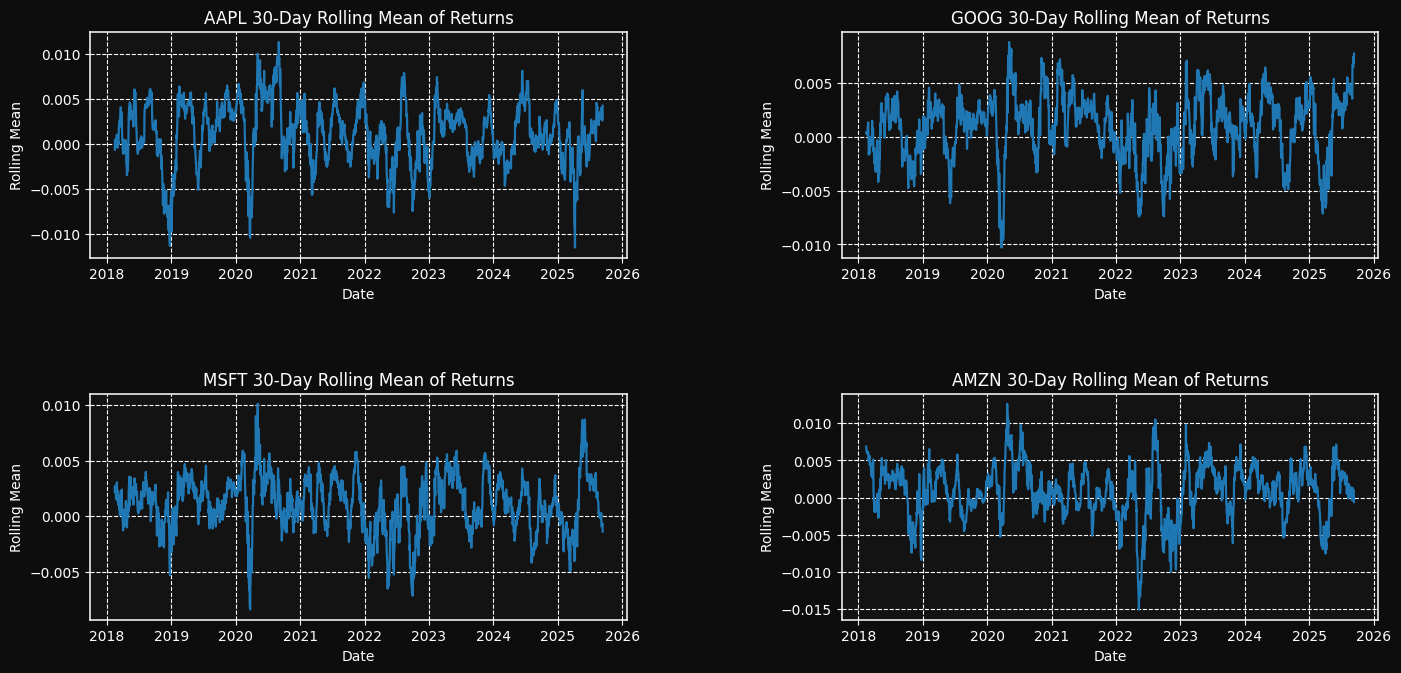


=== Most Recent EWMA (span=30) of Daily Returns ===
        Last EWMA(span=30)
Ticker                    
AAPL              0.002077
AMZN              0.000173
GOOG              0.008285
MSFT              0.000572


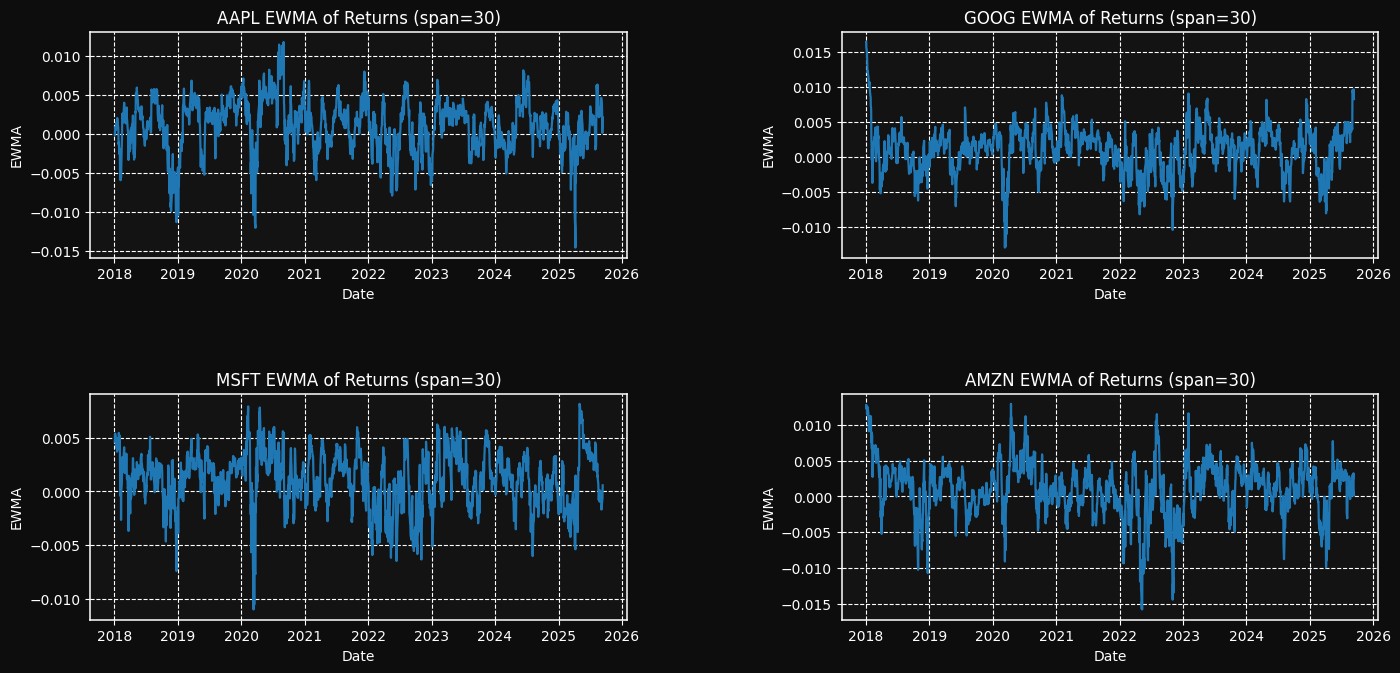

In [ ]:
"""
Average Daily Return + Rolling Mean + EWMA (AAPL, GOOG, MSFT, AMZN)
- Downloads OHLCV (keeps Adj Close)
- Computes daily returns from Adj Close
- Prints daily & annualized stats + approx. Sharpe
- Plots (dark theme, wide spacing so panels don't touch):
    1) Daily return histograms (2×2)
    2) Rolling mean of returns (2×2)           <-- simple rolling mean
    3) EWMA (exponential mean) of returns (2×2) <-- NEW
"""

# ---------- Parameters ----------
tickers   = ["AAPL", "GOOG", "MSFT", "AMZN"]
start     = "2018-01-01"
end       = datetime.today().strftime("%Y-%m-%d")
BINS      = 60
ROLL_W    = 30   # window for simple rolling mean
EWMA_SPAN = 30   # span for EWMA (roughly comparable to ROLL_W)
# Dark styling & spacing (so plots don't touch)
FIG_BG      = "#0d0d0d"     # figure (gap) background
AX_BG_DARK  = "#131313"     # axes panel background
TXT_LIGHT   = "white"       # label/tick/legend color
GRID_LIGHT  = (1, 1, 1, 0.22)
GAP_W, GAP_H = 0.40, 0.60
# --------------------------------

def style_dark_axes(ax):
    ax.set_facecolor(AX_BG_DARK)
    ax.title.set_color(TXT_LIGHT)
    ax.xaxis.label.set_color(TXT_LIGHT)
    ax.yaxis.label.set_color(TXT_LIGHT)
    ax.tick_params(colors=TXT_LIGHT)
    for s in ax.spines.values():
        s.set_color(TXT_LIGHT); s.set_linewidth(1.1)
    ax.grid(True, linestyle="--", color=GRID_LIGHT)

# 1) Download (keep Adj Close)
panel = yf.download(tickers, start=start, end=end, auto_adjust=False, progress=False)
if panel.empty:
    raise RuntimeError("No data downloaded. Check tickers/date range/network.")

# 2) Adjusted Close → returns
if isinstance(panel.columns, pd.MultiIndex):
    adj_close = panel["Adj Close"].copy()
else:  # single ticker fallback
    adj_close = panel[["Adj Close"]].copy()
    adj_close.columns = tickers[:1]

rets = adj_close.pct_change().dropna(how="all")

# 3) Stats
summary = pd.DataFrame(index=rets.columns)
summary["Daily Mean"] = rets.mean()
summary["Daily Std"]  = rets.std()
summary["Ann. Mean"]  = (1 + summary["Daily Mean"])**252 - 1
summary["Ann. Std"]   = summary["Daily Std"] * np.sqrt(252)
summary["Sharpe~"]    = (summary["Daily Mean"] / summary["Daily Std"]) * np.sqrt(252)

print("\n=== Average Daily Return Summary ({} → {}) ===".format(start, end))
print(summary.round(6).sort_values("Ann. Mean", ascending=False))

# 4) Plot — Daily return histograms (2×2)
fig, axes = plt.subplots(2, 2, figsize=(14, 7), sharex=False, sharey=False)
fig.patch.set_facecolor(FIG_BG)
axes = axes.ravel()

for i, t in enumerate(tickers):
    ax = axes[i]
    style_dark_axes(ax)
    if t not in rets.columns or rets[t].dropna().empty:
        ax.set_title(f"{t} — no returns")
        continue
    r = rets[t].dropna()
    ax.hist(r, bins=BINS, edgecolor="black", alpha=0.8)
    ax.set_title(f"{t} Daily Return Histogram")
    ax.set_xlabel("Daily Return"); ax.set_ylabel("Frequency")

fig.subplots_adjust(left=0.06, right=0.98, top=0.92, bottom=0.08,
                    wspace=GAP_W, hspace=GAP_H)
plt.show()

# 5) Rolling mean of returns (simple) — 2×2
roll_mean = rets.rolling(ROLL_W).mean()

# Print the most recent rolling-mean value for each ticker
latest_rm = roll_mean.tail(1).T
latest_rm.columns = [f"Last {ROLL_W}d Mean"]
print(f"\n=== Most Recent {ROLL_W}-Day Rolling Mean of Daily Returns ===")
print(latest_rm.round(6))

fig, axes = plt.subplots(2, 2, figsize=(14, 7), sharex=False, sharey=False)
fig.patch.set_facecolor(FIG_BG)
axes = axes.ravel()

for i, t in enumerate(tickers):
    ax = axes[i]
    style_dark_axes(ax)
    if t not in roll_mean.columns or roll_mean[t].dropna().empty:
        ax.set_title(f"{t} — insufficient data for {ROLL_W}d mean")
        continue
    m = roll_mean[t].dropna()
    ax.plot(m.index, m.values, linewidth=1.6)
    ax.set_title(f"{t} {ROLL_W}-Day Rolling Mean of Returns")
    ax.set_xlabel("Date"); ax.set_ylabel("Rolling Mean")

fig.subplots_adjust(left=0.06, right=0.98, top=0.92, bottom=0.08,
                    wspace=GAP_W, hspace=GAP_H)
plt.show()

# 6) NEW — EWMA (exponential mean) of returns — 2×2
ewma = rets.ewm(span=EWMA_SPAN, adjust=False).mean()

# Print the most recent EWMA value for each ticker
latest_ew = ewma.tail(1).T
latest_ew.columns = [f"Last EWMA(span={EWMA_SPAN})"]
print(f"\n=== Most Recent EWMA (span={EWMA_SPAN}) of Daily Returns ===")
print(latest_ew.round(6))

fig, axes = plt.subplots(2, 2, figsize=(14, 7), sharex=False, sharey=False)
fig.patch.set_facecolor(FIG_BG)
axes = axes.ravel()

for i, t in enumerate(tickers):
    ax = axes[i]
    style_dark_axes(ax)
    if t not in ewma.columns or ewma[t].dropna().empty:
        ax.set_title(f"{t} — insufficient data for EWMA span={EWMA_SPAN}")
        continue
    m = ewma[t].dropna()
    ax.plot(m.index, m.values, linewidth=1.6)
    ax.set_title(f"{t} EWMA of Returns (span={EWMA_SPAN})")
    ax.set_xlabel("Date"); ax.set_ylabel("EWMA")

fig.subplots_adjust(left=0.06, right=0.98, top=0.92, bottom=0.08,
                    wspace=GAP_W, hspace=GAP_H)
plt.show()


4. What was the correlation between different stocks closing prices?

Saved: returns_corr.csv, close_corr.csv


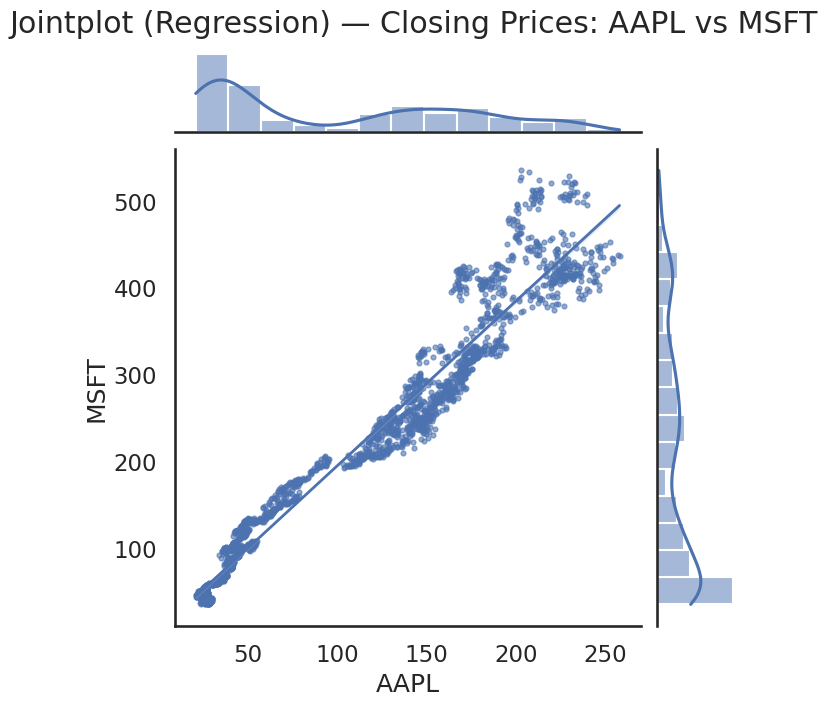

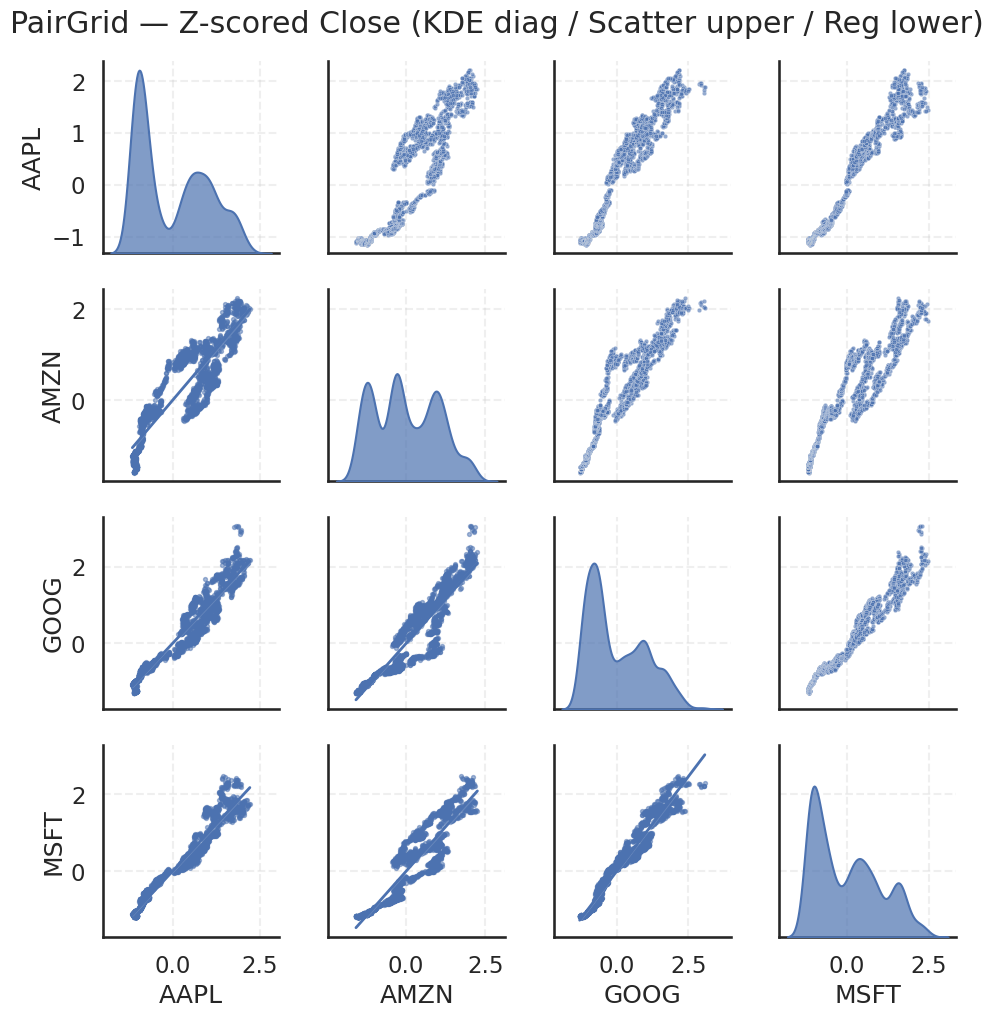

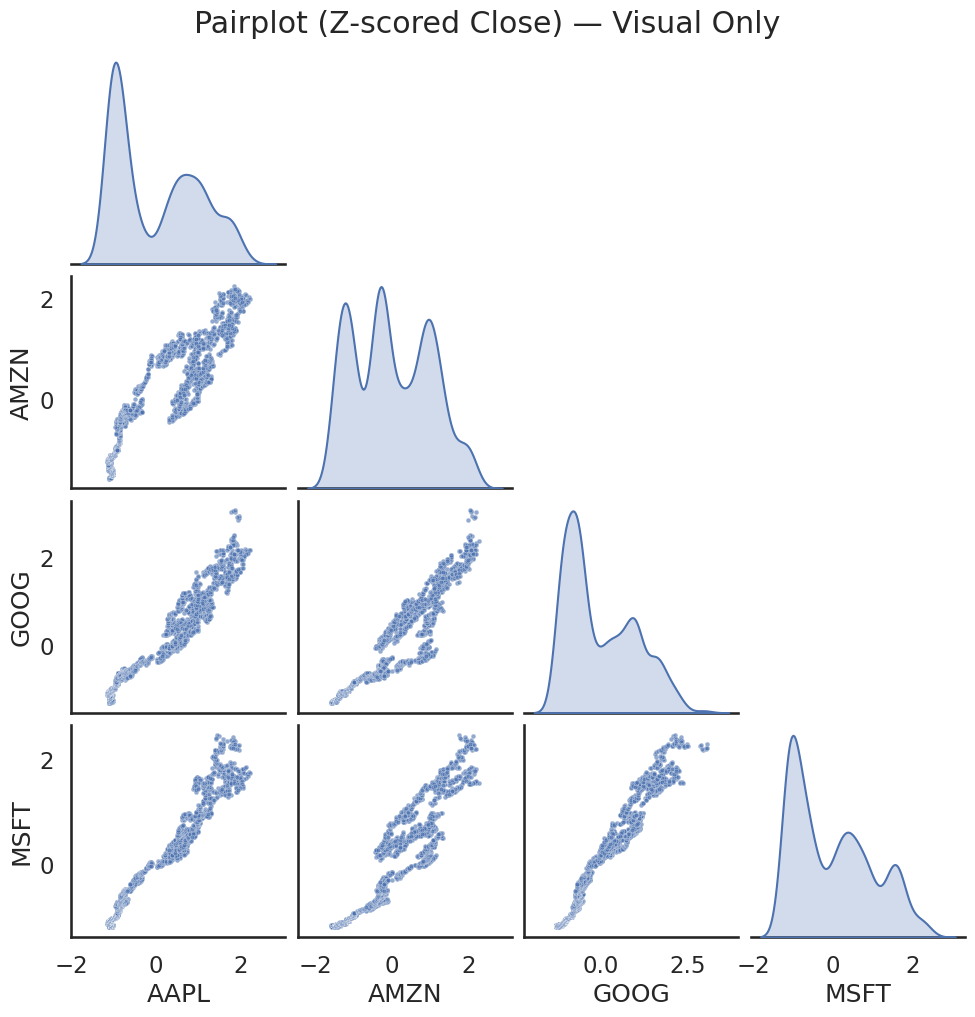

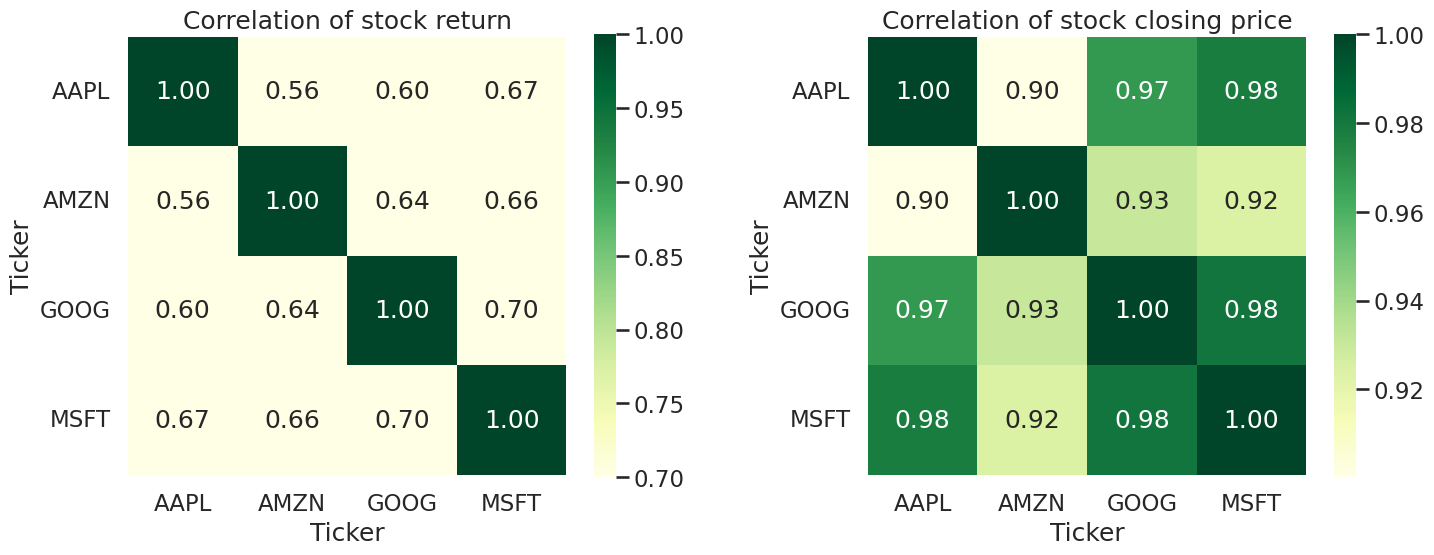


=== Correlation of stock return ===
Ticker  AAPL  AMZN  GOOG  MSFT
Ticker                        
AAPL    1.00  0.56  0.60  0.67
AMZN    0.56  1.00  0.64  0.66
GOOG    0.60  0.64  1.00  0.70
MSFT    0.67  0.66  0.70  1.00

=== Correlation of stock closing price ===
Ticker  AAPL  AMZN  GOOG  MSFT
Ticker                        
AAPL    1.00  0.90  0.97  0.98
AMZN    0.90  1.00  0.93  0.92
GOOG    0.97  0.93  1.00  0.98
MSFT    0.98  0.92  0.98  1.00


In [ ]:
# -------------------- Parameters --------------------
tickers = ["AAPL", "AMZN", "GOOG", "MSFT"]
start   = "2015-01-01"
end     = datetime.today().strftime("%Y-%m-%d")

# True => split/dividend-adjusted closes; False => raw exchange close
ADJUST_FOR_SPLITS = True

# spotlight pair for jointplot
x_ticker = "AAPL"
y_ticker = "MSFT"

sns.set_theme(context="talk", style="white")  # match screenshot style
CMAP = "YlGn"
# ----------------------------------------------------

# 1) Download; keep Close
panel = yf.download(
    tickers, start=start, end=end,
    auto_adjust=ADJUST_FOR_SPLITS, progress=False
)
if panel.empty:
    raise RuntimeError("No data downloaded. Check tickers/date range/network.")

# handle single vs multi-index columns
if isinstance(panel.columns, pd.MultiIndex):
    close = panel["Close"].copy()
else:
    close = panel[["Close"]].copy()
    close.columns = tickers[:1]

# drop empties, keep only requested tickers in specified order
present = [t for t in tickers if t in close.columns]
close   = close[present].dropna(how="all")

# 2) Build returns and correlation matrices
rets       = close.pct_change().dropna(how="all")
corr_ret   = rets.corr(method="pearson")
corr_close = close.corr(method="pearson")

# Save for report/notebook
corr_ret.reindex(index=present, columns=present).to_csv("returns_corr.csv", float_format="%.6f")
corr_close.reindex(index=present, columns=present).to_csv("close_corr.csv", float_format="%.6f")
print("Saved: returns_corr.csv, close_corr.csv")

# -------------------- Reverse-ordered visuals --------------------

# A) Jointplot (spotlight pair) — raw Close
if x_ticker in close.columns and y_ticker in close.columns:
    jp = sns.jointplot(
        data=close, x=x_ticker, y=y_ticker,
        kind="reg", height=7,
        scatter_kws={"s": 12, "alpha": 0.6}, line_kws={"lw": 2}
    )
    jp.fig.suptitle(
        f"Jointplot (Regression) — Closing Prices: {x_ticker} vs {y_ticker}",
        y=1.02
    )
    plt.show()
else:
    print(f"Skipping jointplot: {x_ticker} or {y_ticker} not in columns: {list(close.columns)}")

# B) PairGrid — KDE (diag), Scatter (upper), Regression (lower) on Z-scored Close
close_z = close.apply(lambda s: (s - s.mean()) / s.std(ddof=0))
g = sns.PairGrid(close_z[present])
g.map_diag(sns.kdeplot, fill=True, alpha=0.7)
g.map_upper(sns.scatterplot, s=10, alpha=0.6)
g.map_lower(sns.regplot, scatter_kws={"s": 8, "alpha": 0.5}, line_kws={"lw": 2})
for ax in g.axes.flat:
    if ax is not None:
        ax.grid(True, linestyle="--", alpha=0.3)
g.fig.suptitle("PairGrid — Z-scored Close (KDE diag / Scatter upper / Reg lower)", y=1.02)
plt.show()

# C) Pairplot (corner) — Z-scored Close
pp = sns.pairplot(
    close_z[present], corner=True, diag_kind="kde",
    plot_kws={"s": 12, "alpha": 0.6}
)
pp.fig.suptitle("Pairplot (Z-scored Close) — Visual Only", y=1.02)
plt.show()

# D) HEATMAPS — side-by-side, clearly separated (like screenshot)
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=False, sharey=False)
ax1, ax2 = axes

# Left: returns correlation
sns.heatmap(
    corr_ret.reindex(index=present, columns=present),
    ax=ax1, cmap=CMAP, vmin=max(0.70, float(corr_ret.min().min())), vmax=1.00,
    annot=True, fmt=".2f", square=True, cbar=True, cbar_kws={"shrink": 0.9}
)
ax1.set_title("Correlation of stock return")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)
ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0)

# Right: closing-price correlation
sns.heatmap(
    corr_close.reindex(index=present, columns=present),
    ax=ax2, cmap=CMAP, vmin=max(0.83, float(corr_close.min().min())), vmax=1.00,
    annot=True, fmt=".2f", square=True, cbar=True, cbar_kws={"shrink": 0.9}
)
ax2.set_title("Correlation of stock closing price")
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)
ax2.set_yticklabels(ax2.get_yticklabels(), rotation=0)

fig.subplots_adjust(left=0.06, right=0.98, top=0.90, bottom=0.08, wspace=0.35)
plt.show()

# (Optional) also print the numeric matrices
print("\n=== Correlation of stock return ===")
print(corr_ret.reindex(index=present, columns=present).round(2))
print("\n=== Correlation of stock closing price ===")
print(corr_close.reindex(index=present, columns=present).round(2))

5. How much value do we put at risk by investing in a particular stock?


=== VaR Summary (1-day horizon, daily returns) — shown as % ===
        Daily Mean  Daily Std  Hist VaR 95%  Hist VaR 99%  Gauss VaR 95%  \
Ticker                                                                     
AAPL         0.101      1.832         2.780         4.820          2.912   
AMZN         0.122      2.078         3.063         5.579          3.296   
GOOG         0.099      1.816         2.718         4.920          2.888   
MSFT         0.109      1.707         2.622         4.316          2.698   

        Gauss VaR 99%  CVaR 95%  CVaR 99%  
Ticker                                     
AAPL            4.160     4.164     6.648  
AMZN            4.712     4.630     7.215  
GOOG            4.126     4.138     6.391  
MSFT            3.861     3.846     6.094  
Saved: var_summary.csv


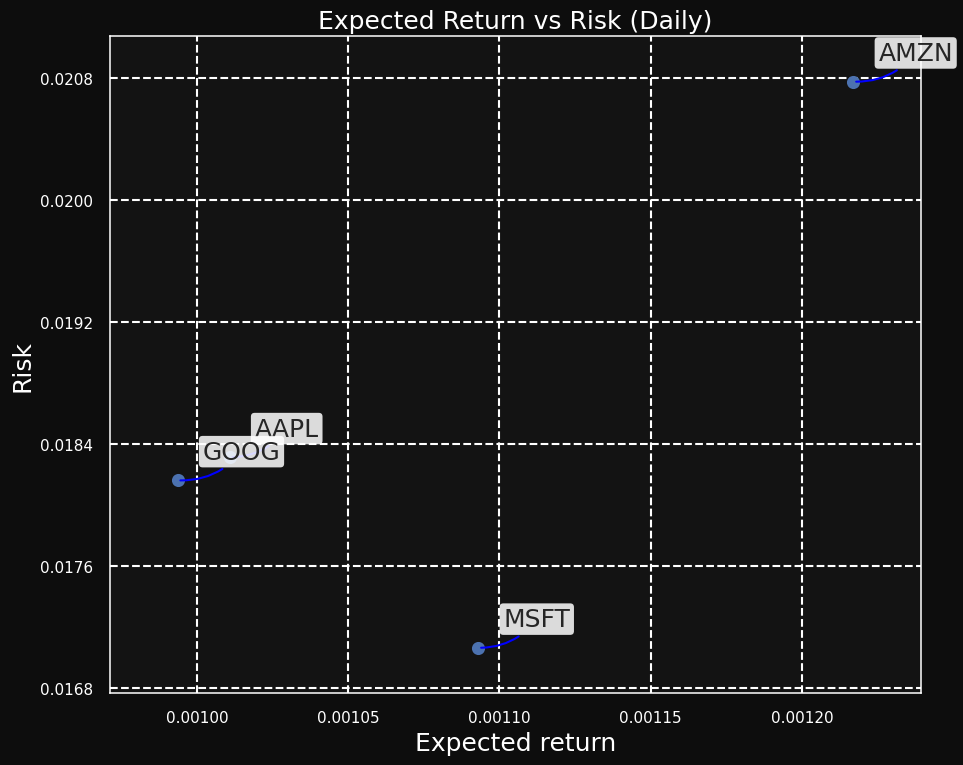

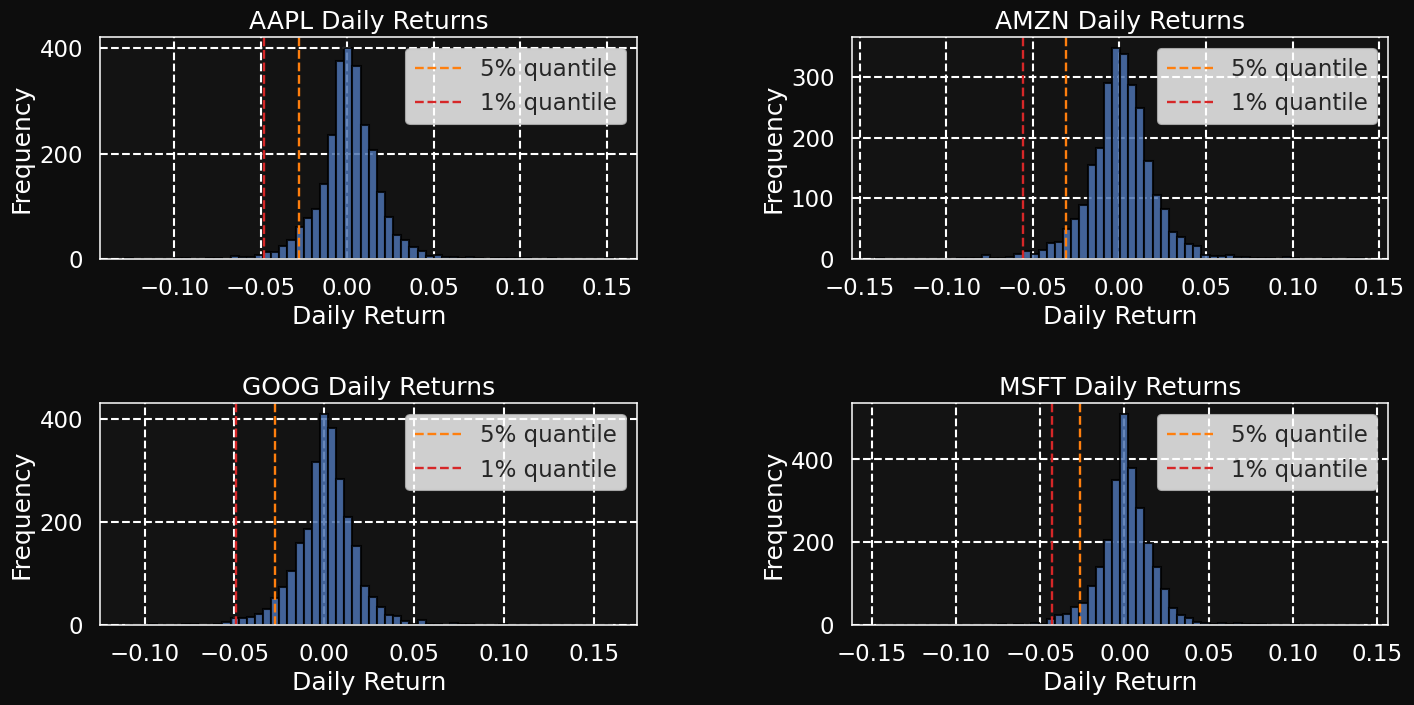

In [ ]:
from matplotlib.ticker import FormatStrFormatter, MaxNLocator, AutoMinorLocator

# -------------------- Parameters --------------------
tickers = ["AAPL", "AMZN", "GOOG", "MSFT"]
start   = "2015-01-01"
end     = datetime.today().strftime("%Y-%m-%d")
AUTO_ADJUST = True   # True => OHLC already adjusted; 'Adj Close' omitted

# VaR settings
ALPHA_95 = 0.05
ALPHA_99 = 0.01
Z_95 = 1.6448536269514722  # N^{-1}(0.95)
Z_99 = 2.3263478740408408  # N^{-1}(0.99)

SHOW_HIST_GRID = True      # set False to skip the histogram grid
# -------------------- Dark theme --------------------
FIG_BG  = "#0d0d0d"       # figure background (gap color)
AX_BG   = "#131313"       # axes background
TXT     = "white"         # text/ticks/spines
GRID_C  = (1, 1, 1, 0.25) # faint white dashed grid

def style_dark_axes(ax):
    ax.set_facecolor(AX_BG)
    ax.title.set_color(TXT)
    ax.xaxis.label.set_color(TXT)
    ax.yaxis.label.set_color(TXT)
    ax.tick_params(colors=TXT)
    for s in ax.spines.values():
        s.set_color(TXT); s.set_linewidth(1.1)
    ax.grid(True, linestyle="--", color=GRID_C)
# ----------------------------------------------------

# 1) Download prices
panel = yf.download(
    tickers, start=start, end=end,
    auto_adjust=AUTO_ADJUST, progress=False
)
if panel.empty:
    raise RuntimeError("No data downloaded. Check tickers/date range/network.")

# 2) Extract a price matrix: prefer Adjusted if present, else Close
def extract_prices(df, tickers):
    if isinstance(df.columns, pd.MultiIndex):
        has_adj = "Adj Close" in df.columns.get_level_values(0)
        px = df["Adj Close"].copy() if has_adj else df["Close"].copy()
    else:
        px = df[["Adj Close"]].copy() if "Adj Close" in df.columns else df[["Close"]].copy()
        px.columns = tickers[:1]  # fallback name fix for single-index
    cols = [t for t in tickers if t in px.columns]
    return px[cols]

prices = extract_prices(panel, tickers)

# 3) Daily returns
tech_rets = prices.pct_change()
rets = tech_rets.dropna(how="all")
rets = rets[[c for c in rets.columns if rets[c].notna().sum() > 0]]
if rets.empty:
    raise RuntimeError("No valid returns after differencing.")

# 4) Stats & VaR
mu    = rets.mean()   # daily expected return
sigma = rets.std()    # daily risk (std)

# Historical VaR (positive = loss magnitude)
hist_var_95 = -rets.quantile(ALPHA_95)
hist_var_99 = -rets.quantile(ALPHA_99)

# Gaussian/Parametric VaR
gauss_var_95 = (Z_95 * sigma) - mu
gauss_var_99 = (Z_99 * sigma) - mu

# CVaR / Expected Shortfall
def cvar(series, alpha):
    q = series.quantile(alpha)
    tail = series[series <= q]
    return -tail.mean()

cvar_95 = rets.apply(cvar, alpha=ALPHA_95)
cvar_99 = rets.apply(cvar, alpha=ALPHA_99)

# 5) Summary table
var_summary = pd.DataFrame({
    "Daily Mean": mu,
    "Daily Std": sigma,
    "Hist VaR 95%": hist_var_95,
    "Hist VaR 99%": hist_var_99,
    "Gauss VaR 95%": gauss_var_95,
    "Gauss VaR 99%": gauss_var_99,
    "CVaR 95%": cvar_95,
    "CVaR 99%": cvar_99
}).reindex(tickers)

print("\n=== VaR Summary (1-day horizon, daily returns) — shown as % ===")
print((var_summary * 100).round(3).astype(float))
var_summary.to_csv("var_summary.csv", float_format="%.8f")
print("Saved: var_summary.csv")

# 6) Scatter — Expected return vs Risk (DECIMAL axis, dark style)
area = np.pi * 20
fig, ax = plt.subplots(figsize=(10, 8))
fig.patch.set_facecolor(FIG_BG)

ax.scatter(mu, sigma, s=area)
ax.set_title('Expected Return vs Risk (Daily)')

# Axis labels (plain decimals)
ax.set_xlabel('Expected return')
ax.set_ylabel('Risk')

# Clear decimal ticks (no sci-notation) & limit count
ax.ticklabel_format(axis='x', style='plain', useOffset=False)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.5f'))  # e.g., 0.00105
ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))  # e.g., 0.0196
ax.xaxis.set_major_locator(MaxNLocator(nbins=6, prune='both'))
ax.yaxis.set_major_locator(MaxNLocator(nbins=6, prune='both'))
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(axis='both', which='major', labelsize=11)
ax.tick_params(axis='both', which='minor', length=3, colors='0.6')
ax.margins(x=0.10, y=0.08)

# Dark styling (like your example)
style_dark_axes(ax)

# Arrow annotations
for label, x, y in zip(rets.columns, mu, sigma):
    ax.annotate(
        label, xy=(x, y), xytext=(18, 12), textcoords='offset points',
        ha='left', va='bottom',
        arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.25'),
        bbox=dict(boxstyle='round,pad=0.15', fc='white', ec='none', alpha=0.85)
    )

fig.tight_layout()
plt.show()

# 7) Optional: per-ticker histograms with VaR lines (dark panels, spaced apart)
if SHOW_HIST_GRID:
    fig, axes = plt.subplots(2, 2, figsize=(14, 7), sharex=False, sharey=False)
    fig.patch.set_facecolor(FIG_BG)
    axes = axes.ravel()

    for i, t in enumerate(tickers):
        ax = axes[i]
        style_dark_axes(ax)

        if t not in rets.columns or rets[t].dropna().empty:
            ax.set_visible(False); continue

        r = rets[t].dropna()
        ax.hist(r, bins=60, edgecolor="black", alpha=0.85)
        ax.axvline(-hist_var_95[t], color="tab:orange", linestyle="--", linewidth=1.7, label="5% quantile")
        ax.axvline(-hist_var_99[t], color="tab:red", linestyle="--", linewidth=1.7, label="1% quantile")
        ax.set_title(f"{t} Daily Returns")
        ax.set_xlabel("Daily Return"); ax.set_ylabel("Frequency")
        ax.legend()

    # wide spacing so panels don't touch (like the screenshot feel)
    fig.subplots_adjust(left=0.06, right=0.98, top=0.92, bottom=0.08, wspace=0.40, hspace=0.65)
    plt.show()

6. Predicting the closing price stock price of MSFT with LSTM Model.

Epoch 1/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - loss: 0.3736 - val_loss: 0.2771
Epoch 2/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.3733 - val_loss: 0.2773
Epoch 3/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.3730 - val_loss: 0.2771
Epoch 4/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 0.3723 - val_loss: 0.2769
Epoch 5/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 0.3724 - val_loss: 0.2767
Epoch 6/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 0.3720 - val_loss: 0.2766
Epoch 7/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.3716 - val_loss: 0.2762
Epoch 8/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - loss: 0.3724 - val_loss: 0.2765
Epoch 9/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - loss: 0.3700 - val_loss: 0.2764
Epoch 10/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.3690 - val_loss: 0.2767
Epoch 11/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.3688 - val_loss: 0.2767
Epoch 12/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.3

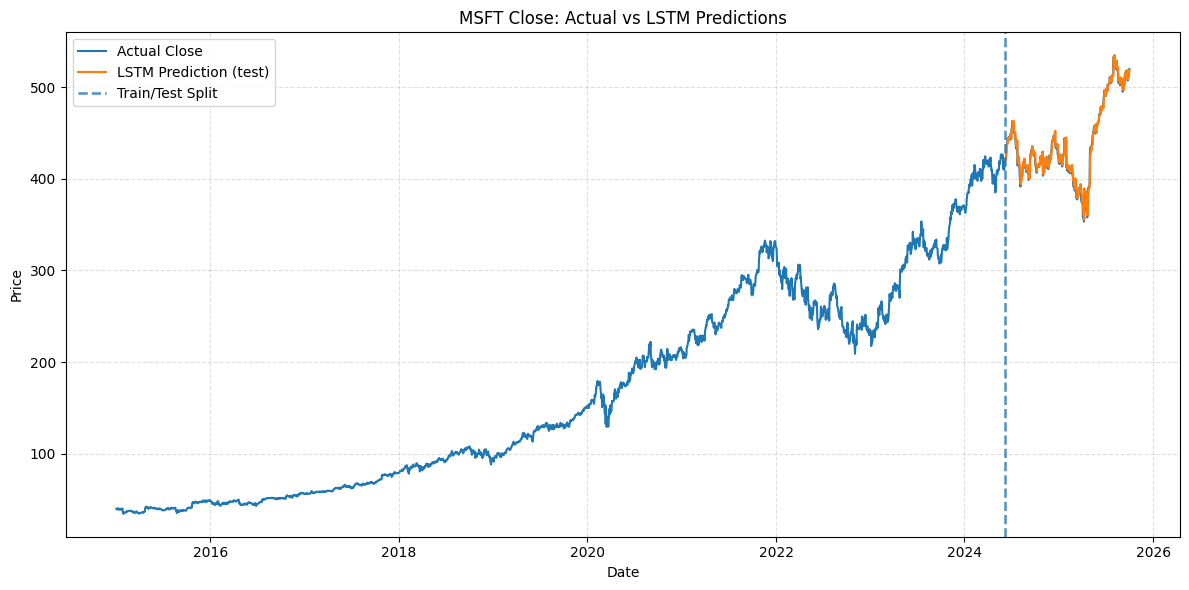

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

import tensorflow as tf
import random
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# ---------------- Params ----------------
SYMBOL      = "MSFT"
START       = "2015-01-01"
END         = datetime.today().strftime("%Y-%m-%d")
LOOKBACK    = 60
TRAIN_SPLIT = 0.75
VAL_FRACTION_OF_REST = 0.50
BATCH_SIZE  = 64
EPOCHS      = 60
LR          = 1e-3
PLOT_DARK   = False

# Calibration controls (keep preds only slightly higher)
SHRINK_TO_1 = 0.50   # 0..1; 0=pure OLS, 1=force slope=1.0
MAX_AMPLIFY = 1.05   # cap slope to <= +5%
MIN_AMPLIFY = 0.90   # optional lower bound
ANCHOR_TO_ACTUAL = True  # teacher-forcing to prevent drift
# ----------------------------------------

# Reproducibility
SEED = 42
np.random.seed(SEED); random.seed(SEED); tf.random.set_seed(SEED)

# ---- 1) Download Close ----
df = yf.download(SYMBOL, start=START, end=END, auto_adjust=True, progress=False)
if df.empty:
    raise RuntimeError("No data downloaded.")
price = df[["Close"]].copy()

# ---- 2) Log-returns; next-day target ----
logret = np.log(price["Close"]).diff().dropna()
logret.name = "logret"

def make_xy(series, lookback):
    X, y, idx = [], [], []
    vals = series.values
    for i in range(lookback, len(vals)):
        X.append(vals[i - lookback:i])
        y.append(vals[i])
        idx.append(series.index[i])
    X = np.array(X).reshape(-1, lookback, 1)
    y = np.array(y).reshape(-1, 1)
    return X, y, np.array(idx)

X_all, y_all, y_idx = make_xy(logret, LOOKBACK)

# ---- 3) Train/Val/Test split ----
n = len(X_all)
n_train = int(n * TRAIN_SPLIT)
X_train, y_train = X_all[:n_train], y_all[:n_train]
X_rest,  y_rest  = X_all[n_train:], y_all[n_train:]
idx_rest = y_idx[n_train:]

cut = int(len(X_rest) * VAL_FRACTION_OF_REST)
X_val, y_val = X_rest[:cut], y_rest[:cut]
X_test, y_test = X_rest[cut:], y_rest[cut:]
idx_val, idx_test = idx_rest[:cut], idx_rest[cut:]

# ---- 4) Scale (fit on train only) ----
xsc = StandardScaler()
ysc = StandardScaler()

X_train_s = xsc.fit_transform(X_train.reshape(-1,1)).reshape(X_train.shape)
X_val_s   = xsc.transform(X_val.reshape(-1,1)).reshape(X_val.shape)
X_test_s  = xsc.transform(X_test.reshape(-1,1)).reshape(X_test.shape)

y_train_s = ysc.fit_transform(y_train)
y_val_s   = ysc.transform(y_val)
y_test_s  = ysc.transform(y_test)

# ---- 5) LSTM ----
model = Sequential([
    Input(shape=(LOOKBACK, 1)),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
              loss=tf.keras.losses.Huber())

es = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
_ = model.fit(
    X_train_s, y_train_s,
    validation_data=(X_val_s, y_val_s),
    epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1,
    callbacks=[es]
)

# ---- 6) Predict (invert scaling) ----
pred_val  = ysc.inverse_transform(model.predict(X_val_s,  verbose=0)).ravel()
pred_test = ysc.inverse_transform(model.predict(X_test_s, verbose=0)).ravel()
y_val_true  = y_val.ravel()
y_test_true = y_test.ravel()

# ---- 7) Conservative calibration on validation ----
ols = LinearRegression().fit(pred_val.reshape(-1,1), y_val_true)
a_ols, b_ols = float(ols.intercept_), float(ols.coef_[0])
b = (1 - SHRINK_TO_1) * b_ols + SHRINK_TO_1 * 1.0
b = float(np.clip(b, MIN_AMPLIFY, MAX_AMPLIFY))
m_true, m_pred = float(np.mean(y_val_true)), float(np.mean(pred_val))
a = m_true - b * m_pred
print(f"Calibration (conservative): a={a:.6g}, b_shrunk={b:.3f} (OLS b={b_ols:.3f})")

pred_val_cal  = a + b * pred_val
pred_test_cal = a + b * pred_test

# ---- 8) Reconstruct price on TEST (teacher-forcing; robust indexing) ----
actual_price_test = price.loc[idx_test, "Close"].to_numpy()

# integer position of first test date in full price index
pos0 = price.index.get_loc(idx_test[0])
if isinstance(pos0, slice):  # safety for non-unique index (unlikely)
    pos0 = pos0.start
assert pos0 > 0, "Need at least one prior close before test start."

# last real close BEFORE first test target (scalar via iloc[row, col])
prev_actual = price.iloc[pos0 - 1, 0]

pred_price_test = np.empty_like(actual_price_test, dtype=float)
for i, r in enumerate(pred_test_cal):
    base = actual_price_test[i-1] if (ANCHOR_TO_ACTUAL and i > 0) else prev_actual
    pred_price_test[i] = base * math.exp(r)

# ---- 9) Metrics ----
mae  = mean_absolute_error(actual_price_test, pred_price_test)
mape = mean_absolute_percentage_error(actual_price_test, pred_price_test) * 100
print(f"Test MAE: {mae:.2f}  |  Test MAPE: {mape:.2f}%")

# ---- 10) Next-day forecast (with conservative calibration) ----
last_window = logret.values[-LOOKBACK:].reshape(1, LOOKBACK, 1)
next_ret_raw = ysc.inverse_transform(
                model.predict(
                    xsc.transform(last_window.reshape(-1,1)).reshape(1,LOOKBACK,1),
                    verbose=0)
              ).ravel()[0]
next_ret_cal = a + b * next_ret_raw
last_close   = price.iloc[-1, 0]                 # scalar via iloc[row, col]
next_close_pred = last_close * math.exp(next_ret_cal)
print(f"Next-day predicted close (one-step): {next_close_pred:.2f}")

# ---- 11) Plot ----
plt.style.use("default")
fig, ax = plt.subplots(figsize=(12, 6))
if PLOT_DARK:
    fig.set_facecolor("#0d0d0d"); ax.set_facecolor("#131313")
    for s in ax.spines.values(): s.set_color("white")
    ax.tick_params(colors="white")
    ax.yaxis.label.set_color("white"); ax.xaxis.label.set_color("white")
    ax.title.set_color("white")
    ax.grid(True, linestyle="--", color=(1,1,1,0.25))
else:
    ax.grid(True, linestyle="--", alpha=0.4)

ax.plot(price.index, price["Close"].values, label="Actual Close", lw=1.5)
ax.plot(idx_test, pred_price_test, label="LSTM Prediction (test)", lw=1.6)
ax.axvline(x=idx_test[0], color="tab:blue", ls="--", lw=1.8, alpha=0.8, label="Train/Test Split")
ax.set_title("MSFT Close: Actual vs LSTM Predictions")
ax.set_xlabel("Date"); ax.set_ylabel("Price")
ax.legend(frameon=True)
plt.tight_layout()
plt.show()

 7. Which works better for tomorrow’s MSFT price and risk: classic models (ARIMA for price, GARCH for volatility) or a small LSTM, judging by RMSE/MAPE for price and how well they predict volatility in calm vs. volatile markets?


▶ Downloading MSFT from 2013-09-18 to 2025-09-15
  ↳ prices in 0.24s
Train: 2013-09-18 → 2023-04-18  (n=2412)
Test : 2023-04-19 → 2025-09-12   (n=603)

▶ Training LSTM
  ↳ LSTM training in 14.12s

▶ Predicting with LSTM (recursive)
  ↳ LSTM prediction in 62.58s

▶ Fitting quick (S)ARIMA candidates
  ↳ SARIMA fit in 36.16s
Chosen (S)ARIMA AIC: -12809.71

▶ Fitting GARCH(1,1) on last 2000 returns
  ↳ GARCH fit+forecast in 0.06s

=== Test Metrics (levels) ===
                                 Model     MAE    RMSE   MAPE%
                     (S)ARIMA (levels) 31.0088 38.2393 17.8870
                         LSTM (levels) 68.0072 79.9141 17.6655
GARCH mean-only (levels, illustrative) 60.6378 84.2123 27.7046


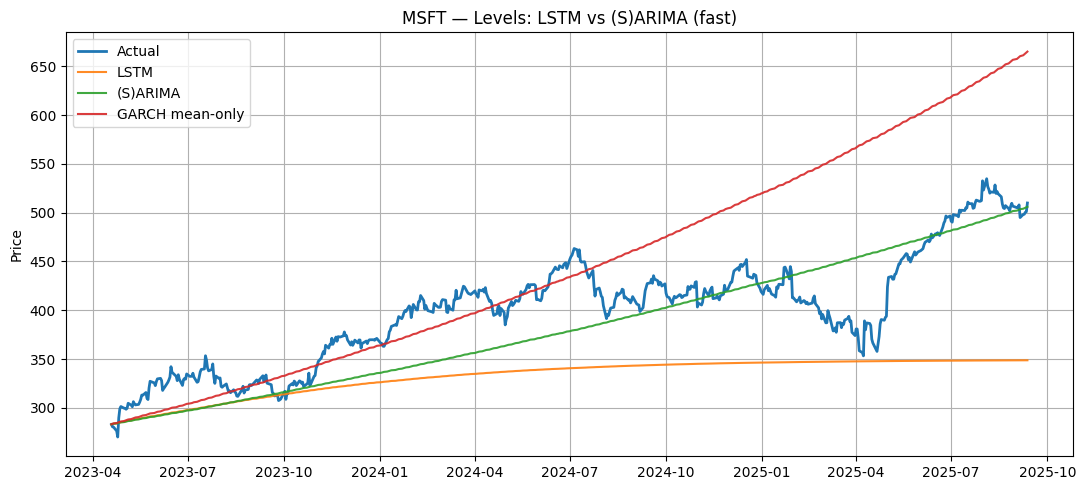

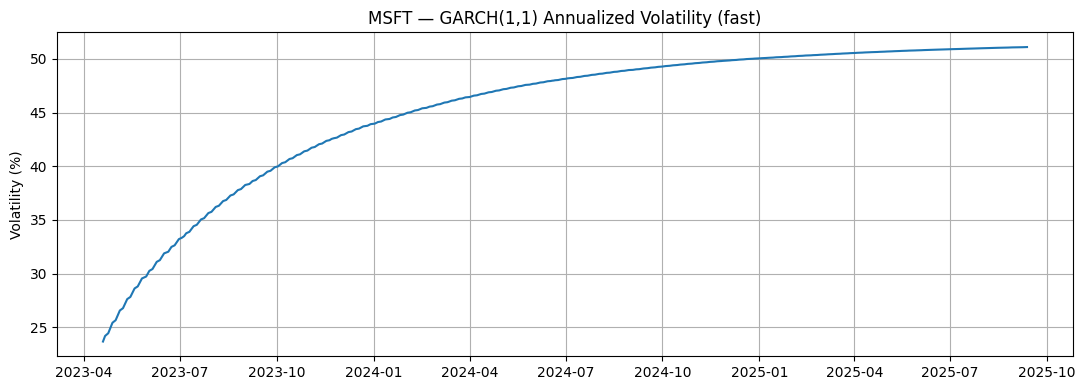

In [ ]:
# ===========================================
# FAST Classical vs Deep Learning (One Cell) — FINAL FIX
# LSTM (levels) | quick (S)ARIMA (levels) | fast GARCH(1,1) (vol)
# Fixes:
#  - Off-by-one in LSTM windows
#  - SARIMA predicted_mean -> 1-D
#  - Robust cum_from_returns (scalar math; never returns (h,1))
#  - Force 1-D before pd.Series(...)
# ===========================================
import warnings, math, numpy as np, pandas as pd, matplotlib.pyplot as plt
from datetime import datetime, timedelta
from time import time
warnings.filterwarnings("ignore")

# ---------- SPEED PRESET ----------
SPEED_MODE   = "full"   # "mini" | "fast" | "full"

# ---------- CONFIG ----------
SYMBOL       = "MSFT"
END          = datetime.today().strftime("%Y-%m-%d")
TRAIN_FRAC   = 0.80

# Presets by speed
if SPEED_MODE == "mini":
    YEARS_BACK         = 5
    LSTM_EPOCHS        = 8
    LSTM_UNITS         = 32
    LSTM_DROPOUT       = 0.10
    LOOKBACK           = 30
    SARIMA_CANDIDATES  = [
        ((1,0,1),(0,0,0,0)),
        ((1,1,1),(0,0,0,0)),
        ((1,0,1),(1,0,1,5)),   # ~weekly seasonality
    ]
    GARCH_LAST_N       = 800
    SARIMAX_MAXITER    = 100
    GARCH_MAXITER      = 200
elif SPEED_MODE == "fast":
    YEARS_BACK         = 8
    LSTM_EPOCHS        = 18
    LSTM_UNITS         = 48
    LSTM_DROPOUT       = 0.15
    LOOKBACK           = 45
    SARIMA_CANDIDATES  = [
        ((1,0,1),(0,0,0,0)), ((1,1,1),(0,0,0,0)),
        ((2,0,1),(0,0,0,0)), ((1,0,2),(0,0,0,0)),
        ((1,0,1),(1,0,1,5)), ((1,0,1),(1,0,1,21)),
    ]
    GARCH_LAST_N       = 1200
    SARIMAX_MAXITER    = 200
    GARCH_MAXITER      = 300
else:  # "full"
    YEARS_BACK         = 12
    LSTM_EPOCHS        = 30
    LSTM_UNITS         = 64
    LSTM_DROPOUT       = 0.20
    LOOKBACK           = 60
    SARIMA_CANDIDATES  = [
        ((p,d,q),(0,0,0,0)) for p in (0,1,2) for d in (0,1) for q in (0,1,2)
    ] + [((1,0,1),(1,0,1,5)), ((1,0,1),(1,0,1,21))]
    GARCH_LAST_N       = 2000
    SARIMAX_MAXITER    = 300
    GARCH_MAXITER      = 400

START = (datetime.today() - timedelta(days=365*YEARS_BACK)).strftime("%Y-%m-%d")

# ---------- IMPORTS ----------
import yfinance as yf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

try:
    from arch import arch_model
    HAVE_ARCH = True
except Exception:
    HAVE_ARCH = False
    print("NOTE: 'arch' not installed. Skip GARCH or: pip install arch")

# ---------- UTILS ----------
def tic(msg=""):
    print(f"\n▶ {msg}"); return time()
def toc(t0, msg="done"):
    print(f"  ↳ {msg} in {time()-t0:.2f}s")

def rmse(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true, float), np.array(y_pred, float)
    eps = 1e-8
    return np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), eps))) * 100

def fetch_prices(symbol, start, end):
    t0 = tic(f"Downloading {symbol} from {start} to {end}")
    df = yf.download(symbol, start=start, end=end, auto_adjust=True, progress=False)
    toc(t0, "prices")
    if "Close" not in df or len(df) < 250:
        raise ValueError("Not enough data. Try increasing YEARS_BACK or check ticker.")
    df = df[["Close"]].dropna().copy()
    df["LogRet"] = np.log(df["Close"]).diff()
    return df

def split_series(df, train_frac=0.8):
    cut = int(len(df)*train_frac)
    return df.iloc[:cut].copy(), df.iloc[cut:].copy()

def cum_from_returns(last_price, returns):
    """
    Robust cumulative price path from log-returns.
    Forces scalar math at each step; always returns 1-D numpy array shape (h,).
    """
    rets = np.asarray(returns, float).reshape(-1)  # ensure 1-D
    out = np.empty(len(rets), dtype=float)
    prev = float(last_price)
    exp = math.exp
    for i, r in enumerate(rets):
        prev = prev * exp(float(r))  # force scalar
        out[i] = prev
    return out  # shape (h,)

def plot_overlay(actual, preds_dict, title="Forecast vs Actual", ylabel="Price"):
    plt.figure(figsize=(11,5))
    plt.plot(actual.index, actual.values, label="Actual", linewidth=2)
    for label, s in preds_dict.items():
        plt.plot(s.index, s.values, label=label, alpha=0.9)
    plt.title(title); plt.ylabel(ylabel); plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

# ---------- LSTM (quick) ----------
def make_supervised(series_scaled, lookback):
    """
    X[t] = series[t:t+lookback], y[t] = series[t+lookback].
    Drop the final window so X and y lengths match.
    """
    n = len(series_scaled)
    if n <= lookback:
        raise ValueError(f"Series too short for lookback={lookback} (n={n}). Lower LOOKBACK.")
    X_win = np.lib.stride_tricks.sliding_window_view(series_scaled, lookback)  # (n-lookback+1, lookback)
    X = X_win[:-1]                              # drop last window (no next target)
    y = series_scaled[lookback:]                # targets
    n_min = min(len(X), len(y))
    X = X[:n_min].astype(np.float32)[..., np.newaxis]
    y = y[:n_min].astype(np.float32)
    return X, y

def build_lstm(input_shape, units, dropout, lr):
    model = Sequential([Input(shape=input_shape),
                        LSTM(units),
                        Dropout(dropout),
                        Dense(1)])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss="mse")
    return model

def train_lstm_and_predict(train_close, test_close, lookback, epochs, units, dropout):
    # Scale on TRAIN only
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_close.values.reshape(-1,1)).ravel()
    X_tr, y_tr = make_supervised(train_scaled, lookback)

    model = build_lstm((lookback,1), units, dropout, lr=1e-3)
    es = EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
    t0 = tic("Training LSTM")
    model.fit(X_tr, y_tr, epochs=epochs, batch_size=64, validation_split=0.15,
              callbacks=[es], verbose=0)
    toc(t0, "LSTM training")

    # Recursive prediction across TEST
    test_scaled = scaler.transform(test_close.values.reshape(-1,1)).ravel()
    window = train_scaled[-lookback:].copy()
    preds_scaled = np.empty(len(test_scaled), dtype=np.float32)
    t0 = tic("Predicting with LSTM (recursive)")
    for i in range(len(test_scaled)):
        x = window.reshape(1, lookback, 1)
        yhat = model.predict(x, verbose=0)[0,0]
        preds_scaled[i] = yhat
        window = np.concatenate([window[1:], [yhat]])
    toc(t0, "LSTM prediction")
    preds = scaler.inverse_transform(preds_scaled.reshape(-1,1)).ravel()
    return pd.Series(preds, index=test_close.index)

# ---------- quick (S)ARIMA ----------
def quick_sarima(y_train, candidates, maxiter=150):
    best = None
    best_aic = np.inf
    for (order, seasonal_order) in candidates:
        try:
            m = SARIMAX(y_train, order=order,
                        seasonal_order=seasonal_order,
                        trend='c',
                        enforce_stationarity=False, enforce_invertibility=False)
            r = m.fit(disp=False, maxiter=maxiter)
            if r.aic < best_aic:
                best, best_aic = r, r.aic
        except Exception:
            continue
    return best, best_aic

# ---------- GARCH (fast) ----------
def fast_garch(y_train, last_price, horizon, maxiter=300):
    am = arch_model(y_train*100.0, p=1, q=1, mean='constant', vol='GARCH', dist='t')
    res = am.fit(disp='off', options={"maxiter": maxiter})
    fc = res.forecast(horizon=horizon)
    mu  = (fc.mean.iloc[-1].values / 100.0)            # mean returns (h steps)
    var = (fc.variance.iloc[-1].values / (100.0**2))   # variance of returns
    vol = np.sqrt(var)
    price_path = cum_from_returns(last_price, mu)
    return mu, vol, pd.Series(price_path)

# ===========================================
# 1) Load & Split
# ===========================================
df = fetch_prices(SYMBOL, START, END)
train, test = split_series(df, TRAIN_FRAC)
print(f"Train: {train.index[0].date()} → {train.index[-1].date()}  (n={len(train)})")
print(f"Test : {test.index[0].date()} → {test.index[-1].date()}   (n={len(test)})")

# ===========================================
# 2) LSTM (levels)
# ===========================================
lstm_pred = train_lstm_and_predict(
    train_close=train["Close"], test_close=test["Close"],
    lookback=LOOKBACK, epochs=LSTM_EPOCHS,
    units=LSTM_UNITS, dropout=LSTM_DROPOUT
)

# ===========================================
# 3) quick (S)ARIMA on log-returns → rebuild to prices (robust 1-D)
# ===========================================
y_tr = train["LogRet"].dropna()
t0 = tic("Fitting quick (S)ARIMA candidates")
sarima_res, aic = quick_sarima(y_tr, SARIMA_CANDIDATES, maxiter=SARIMAX_MAXITER)
toc(t0, "SARIMA fit")
if sarima_res is None:
    raise RuntimeError("All SARIMA candidates failed; try SPEED_MODE='fast' or increase YEARS_BACK.")

h = len(test)
fc_obj = sarima_res.get_forecast(steps=h)
# Ensure 1-D returns
fc_rets_1d = np.asarray(fc_obj.predicted_mean, dtype=float).reshape(-1)
last_close = float(train["Close"].iloc[-1])
sarima_prices = cum_from_returns(last_close, fc_rets_1d)  # shape (h,)
sarima_pred  = pd.Series(np.ravel(sarima_prices), index=test.index)  # force 1-D

print(f"Chosen (S)ARIMA AIC: {aic:.2f}")

# ===========================================
# 4) GARCH(1,1) volatility (fast)
# ===========================================
ann_vol_series, garch_price_series = None, None
if HAVE_ARCH:
    y_g = y_tr.tail(GARCH_LAST_N).dropna()
    t0 = tic(f"Fitting GARCH(1,1) on last {len(y_g)} returns")
    mu, vol, garch_price = fast_garch(y_g, last_close, horizon=h, maxiter=GARCH_MAXITER)
    toc(t0, "GARCH fit+forecast")
    ann_vol_series = pd.Series(vol*np.sqrt(252)*100.0, index=test.index)  # %
    garch_price_series = pd.Series(np.ravel(garch_price.values), index=test.index)
else:
    print("Skipping GARCH (arch not installed).")

# ===========================================
# 5) Metrics & Plots (quick)
# ===========================================
def add_metrics(name, actual, pred):
    return {"Model": name,
            "MAE": mean_absolute_error(actual, pred),
            "RMSE": rmse(actual, pred),
            "MAPE%": mape(actual, pred)}

metrics = [
    add_metrics("LSTM (levels)",     test["Close"], lstm_pred),
    add_metrics("(S)ARIMA (levels)", test["Close"], sarima_pred),
]
if garch_price_series is not None:
    metrics.append(add_metrics("GARCH mean-only (levels, illustrative)", test["Close"], garch_price_series))

metrics_df = pd.DataFrame(metrics).sort_values("RMSE")
print("\n=== Test Metrics (levels) ===")
print(metrics_df.to_string(index=False, float_format=lambda x: f"{x:,.4f}"))

overlay = {"LSTM": lstm_pred, "(S)ARIMA": sarima_pred}
if garch_price_series is not None:
    overlay["GARCH mean-only"] = garch_price_series

plot_overlay(test["Close"], overlay, title=f"{SYMBOL} — Levels: LSTM vs (S)ARIMA (fast)")

if ann_vol_series is not None:
    plt.figure(figsize=(11,4))
    plt.plot(ann_vol_series.index, ann_vol_series.values)
    plt.title(f"{SYMBOL} — GARCH(1,1) Annualized Volatility (fast)")
    plt.ylabel("Volatility (%)"); plt.grid(True);
    plt.tight_layout();
    plt.show()

8. Hypothesis test for MSFT Stock in Pandemic vs Pre-pandemic situation.

Sample sizes (trading days):
  Pre-pandemic: 1258
  Pandemic:     465

Annualized statistics (log returns):
  Mean (pre): 26.65%,  Vol (pre): 23.25%
  Mean (pan): 40.46%,  Vol (pan): 34.63%

H01 (Returns): mean(pandemic) < mean(pre)
  Welch t-test: t = 0.502, two-tailed p = 0.6161, one-tailed p = 0.6919
  Means (daily, log): pre = 0.001057, pan = 0.001606
  Conclusion (α=0.05): Fail to reject H0.
  Mann-Whitney U: U = 285510, two-sided p = 0.4468, one-tailed p = 0.7766

H02 (Volatility): var(pandemic) > var(pre)
  F-test: F = 2.219 (df1=464, df2=1257), one-tailed p = 0.0000
  Variances (daily, log): pre = 0.00021452, pan = 0.00047595
  Conclusion (α=0.05): Reject H0 (pandemic associated with higher volatility).


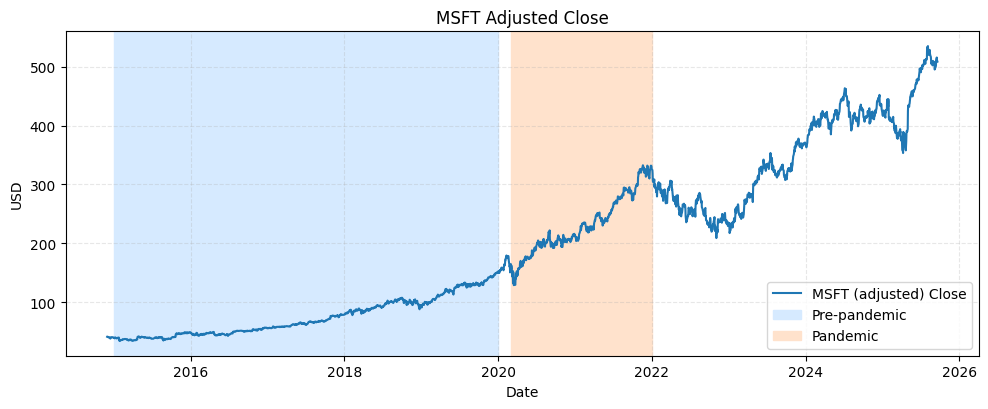

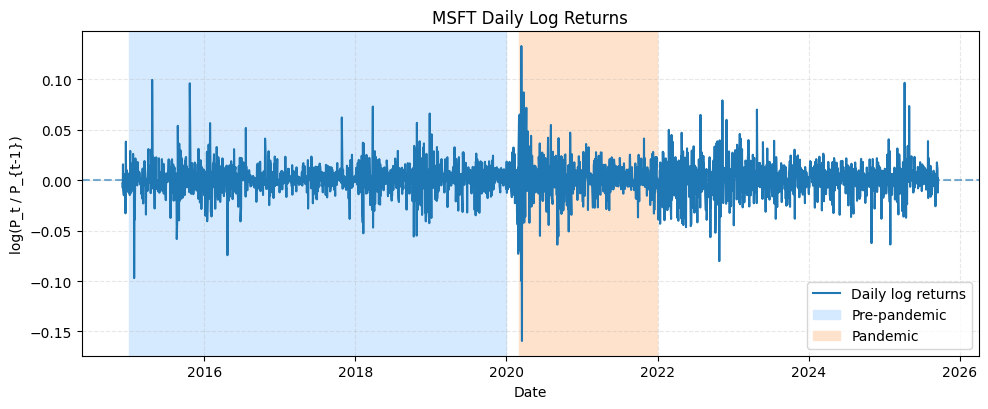

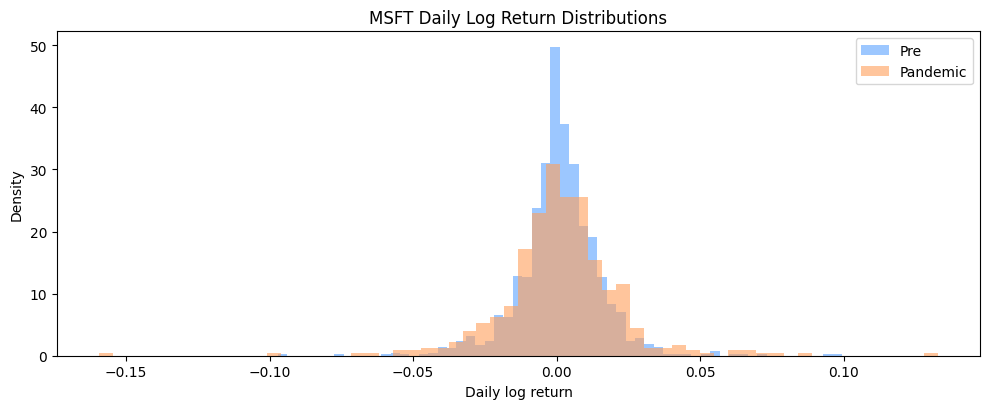

In [ ]:
"""
MSFT pandemic vs pre-pandemic hypothesis tests
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import yfinance as yf

# ---------------- Periods ----------------
pre_start, pre_end = "2015-01-01", "2019-12-31"
pandemic_start, pandemic_end = "2020-03-01", "2021-12-31"

# ---------------- Download MSFT ----------------
DL_START, DL_END = "2014-12-01", "2025-12-31"

px_raw = yf.download(
    "MSFT",
    start=DL_START,
    end=DL_END,
    progress=False,
    auto_adjust=True,   # 'Close' is already adjusted
)

# Robust column selection
if "Close" in px_raw.columns:
    price_col = "Close"
elif "Adj Close" in px_raw.columns:
    price_col = "Adj Close"
else:
    raise KeyError(f"No price column found. Columns: {list(px_raw.columns)}")

# Keep single column (DataFrame) then squeeze to 1-D Series
px = px_raw[[price_col]].rename(columns={price_col: "AdjClose"}).dropna()
price = px.squeeze("columns")              # -> 1-D Series
price = pd.Series(price, name="AdjClose")  # explicit Series

# ---------------- Compute Daily Log Returns (Series) ----------------
ret = np.log(price).diff()     # Series
ret = pd.to_numeric(ret, errors="coerce").dropna()
ret.name = "log_ret"

# ---------------- Slice Periods (as Series) ----------------
ret_pre = ret.loc[pre_start:pre_end].dropna()
ret_pan = ret.loc[pandemic_start:pandemic_end].dropna()

print("Sample sizes (trading days):")
print(f"  Pre-pandemic: {len(ret_pre)}")
print(f"  Pandemic:     {len(ret_pan)}")

# ---------------- Descriptive Stats (scalar-safe) ----------------
def ann_mean_std(x, trading_days=252):
    s = pd.Series(x).dropna()
    mu = float(s.mean()) * trading_days
    sd = float(s.std(ddof=1)) * np.sqrt(trading_days)
    return mu, sd

mu_pre_a, sd_pre_a = ann_mean_std(ret_pre)
mu_pan_a, sd_pan_a = ann_mean_std(ret_pan)

print("\nAnnualized statistics (log returns):")
print(f"  Mean (pre): {mu_pre_a:.2%},  Vol (pre): {sd_pre_a:.2%}")
print(f"  Mean (pan): {mu_pan_a:.2%},  Vol (pan): {sd_pan_a:.2%}")

# ---------------- H01: Mean return drop (Welch t-test, one-tailed) ----------------
t_stat, p_two = stats.ttest_ind(ret_pan, ret_pre, equal_var=False, nan_policy="omit")
p_one_returns = p_two / 2 if (float(ret_pan.mean()) < float(ret_pre.mean())) else 1 - (p_two / 2)

print("\nH01 (Returns): mean(pandemic) < mean(pre)")
print(f"  Welch t-test: t = {t_stat:.3f}, two-tailed p = {p_two:.4f}, one-tailed p = {p_one_returns:.4f}")
print(f"  Means (daily, log): pre = {float(ret_pre.mean()):.6f}, pan = {float(ret_pan.mean()):.6f}")
print("  Conclusion (α=0.05):", "Reject H0 (pandemic negatively affects MSFT returns)." if p_one_returns < 0.05 else "Fail to reject H0.")

# Robustness: Mann–Whitney U (one-tailed: pre > pan)
u_stat, p_two_mw = stats.mannwhitneyu(ret_pre, ret_pan, alternative="two-sided")
p_one_mw = p_two_mw / 2 if (float(ret_pre.median()) > float(ret_pan.median())) else 1 - (p_two_mw / 2)
print(f"  Mann-Whitney U: U = {u_stat:.0f}, two-sided p = {p_two_mw:.4f}, one-tailed p = {p_one_mw:.4f}")

# ---------------- H02: Higher volatility (F-test one-tailed) ----------------
var_pre = float(ret_pre.var(ddof=1))
var_pan = float(ret_pan.var(ddof=1))
df1, df2 = len(ret_pan) - 1, len(ret_pre) - 1
F = var_pan / var_pre
p_one_var = 1 - stats.f.cdf(F, df1, df2)

print("\nH02 (Volatility): var(pandemic) > var(pre)")
print(f"  F-test: F = {F:.3f} (df1={df1}, df2={df2}), one-tailed p = {p_one_var:.4f}")
print(f"  Variances (daily, log): pre = {var_pre:.8f}, pan = {var_pan:.8f}")
print("  Conclusion (α=0.05):", "Reject H0 (pandemic associated with higher volatility)." if p_one_var < 0.05 else "Fail to reject H0.")

# ---------------- Plots (with distinct window colors) ----------------
PRE_COLOR = "#d6eaff"   # light blue
PAN_COLOR = "#ffe2cc"   # light orange
SHADE_ALPHA = 1.0       # 1.0 = solid; try 0.25 for translucent

# 1) Price with windows
plt.figure(figsize=(10,4.2))
plt.plot(price.index, price.values, label="MSFT (adjusted) Close")
plt.axvspan(pd.to_datetime(pre_start), pd.to_datetime(pre_end),
            color=PRE_COLOR, alpha=SHADE_ALPHA, label="Pre-pandemic")
plt.axvspan(pd.to_datetime(pandemic_start), pd.to_datetime(pandemic_end),
            color=PAN_COLOR, alpha=SHADE_ALPHA, label="Pandemic")
plt.title("MSFT Adjusted Close")
plt.ylabel("USD"); plt.xlabel("Date"); plt.grid(True, linestyle="--", alpha=0.3)
plt.legend(); plt.tight_layout()
plt.show()

# 2) Daily log returns with windows
plt.figure(figsize=(10,4.2))
plt.plot(ret.index, ret.values, label="Daily log returns")
plt.axvspan(pd.to_datetime(pre_start), pd.to_datetime(pre_end),
            color=PRE_COLOR, alpha=SHADE_ALPHA, label="Pre-pandemic")
plt.axvspan(pd.to_datetime(pandemic_start), pd.to_datetime(pandemic_end),
            color=PAN_COLOR, alpha=SHADE_ALPHA, label="Pandemic")
plt.axhline(0, linestyle="--", alpha=0.6)
plt.title("MSFT Daily Log Returns")
plt.ylabel("log(P_t / P_{t-1})"); plt.xlabel("Date"); plt.grid(True, linestyle="--", alpha=0.3)
plt.legend(); plt.tight_layout()
plt.show()

# 3) Distribution comparison (optional)
plt.figure(figsize=(10,4.2))
bins = 60
plt.hist(ret_pre, bins=bins, alpha=0.6, density=True, label="Pre", color="#5aa2ff")
plt.hist(ret_pan, bins=bins, alpha=0.6, density=True, label="Pandemic", color="#ff9f5a")
plt.title("MSFT Daily Log Return Distributions")
plt.xlabel("Daily log return"); plt.ylabel("Density")
plt.legend(); plt.tight_layout()
plt.show()